In [ ]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(patchwork)
library(stringr)
library(ggplot2)

In [ ]:
## load gene by cell matrices from all samples into individual seurat objects
seurat_obj_ls <- 
    lapply(c('iso-F-04','iso-F-22','iso-F-35','iso-M-00','iso-M-23','iso-M-40','soc-F-05','soc-F-24','soc-F-36','soc-M-01','soc-M-25','soc-M-41'),
       function(x){
           cell.use <- read.csv(paste0("./samples/",x,".Rat.allCells.csv"))%>% 
            filter(pass=="True") %>%
            pull(X)
        Read10X(paste0("alignment/",x,".Rat/",x,".Rat.star.solo/GeneFull_Ex50pAS/raw/")) %>%
           CreateSeuratObject(project = "Rat", min.cells = 3, min.features = 200) %>%       
            subset(cells = cell.use)
           })

In [3]:
## merge all individual objects into one
Seurat_merged <- merge(seurat_obj_ls[[1]],seurat_obj_ls[-1],project="Rat",
                       add.cell.ids =c('iso-F-04','iso-F-22','iso-F-35','iso-M-00','iso-M-23','iso-M-40','soc-F-05','soc-F-24','soc-F-36','soc-M-01','soc-M-25','soc-M-41'))

In [4]:
Seurat_merged

An object of class Seurat 
26597 features across 76385 samples within 1 assay 
Active assay: RNA (26597 features, 0 variable features)
 12 layers present: counts.1, counts.2, counts.3, counts.4, counts.5, counts.6, counts.7, counts.8, counts.9, counts.10, counts.11, counts.12

In [5]:
Seurat_merged[["RNA"]] <-JoinLayers(Seurat_merged[["RNA"]])

In [6]:
Seurat_merged

An object of class Seurat 
26597 features across 76385 samples within 1 assay 
Active assay: RNA (26597 features, 0 variable features)
 1 layer present: counts

## QC and Cell-level filtering

In [7]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
Seurat_merged[["percent.mt"]] <- PercentageFeatureSet(Seurat_merged, pattern = "^Mt-")

In [8]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

In [9]:
# Visualize QC metrics as a violin plot
p1 <- VlnPlot(Seurat_merged, features = c("nFeature_RNA", "nCount_RNA"), ncol = 3,layer='counts')

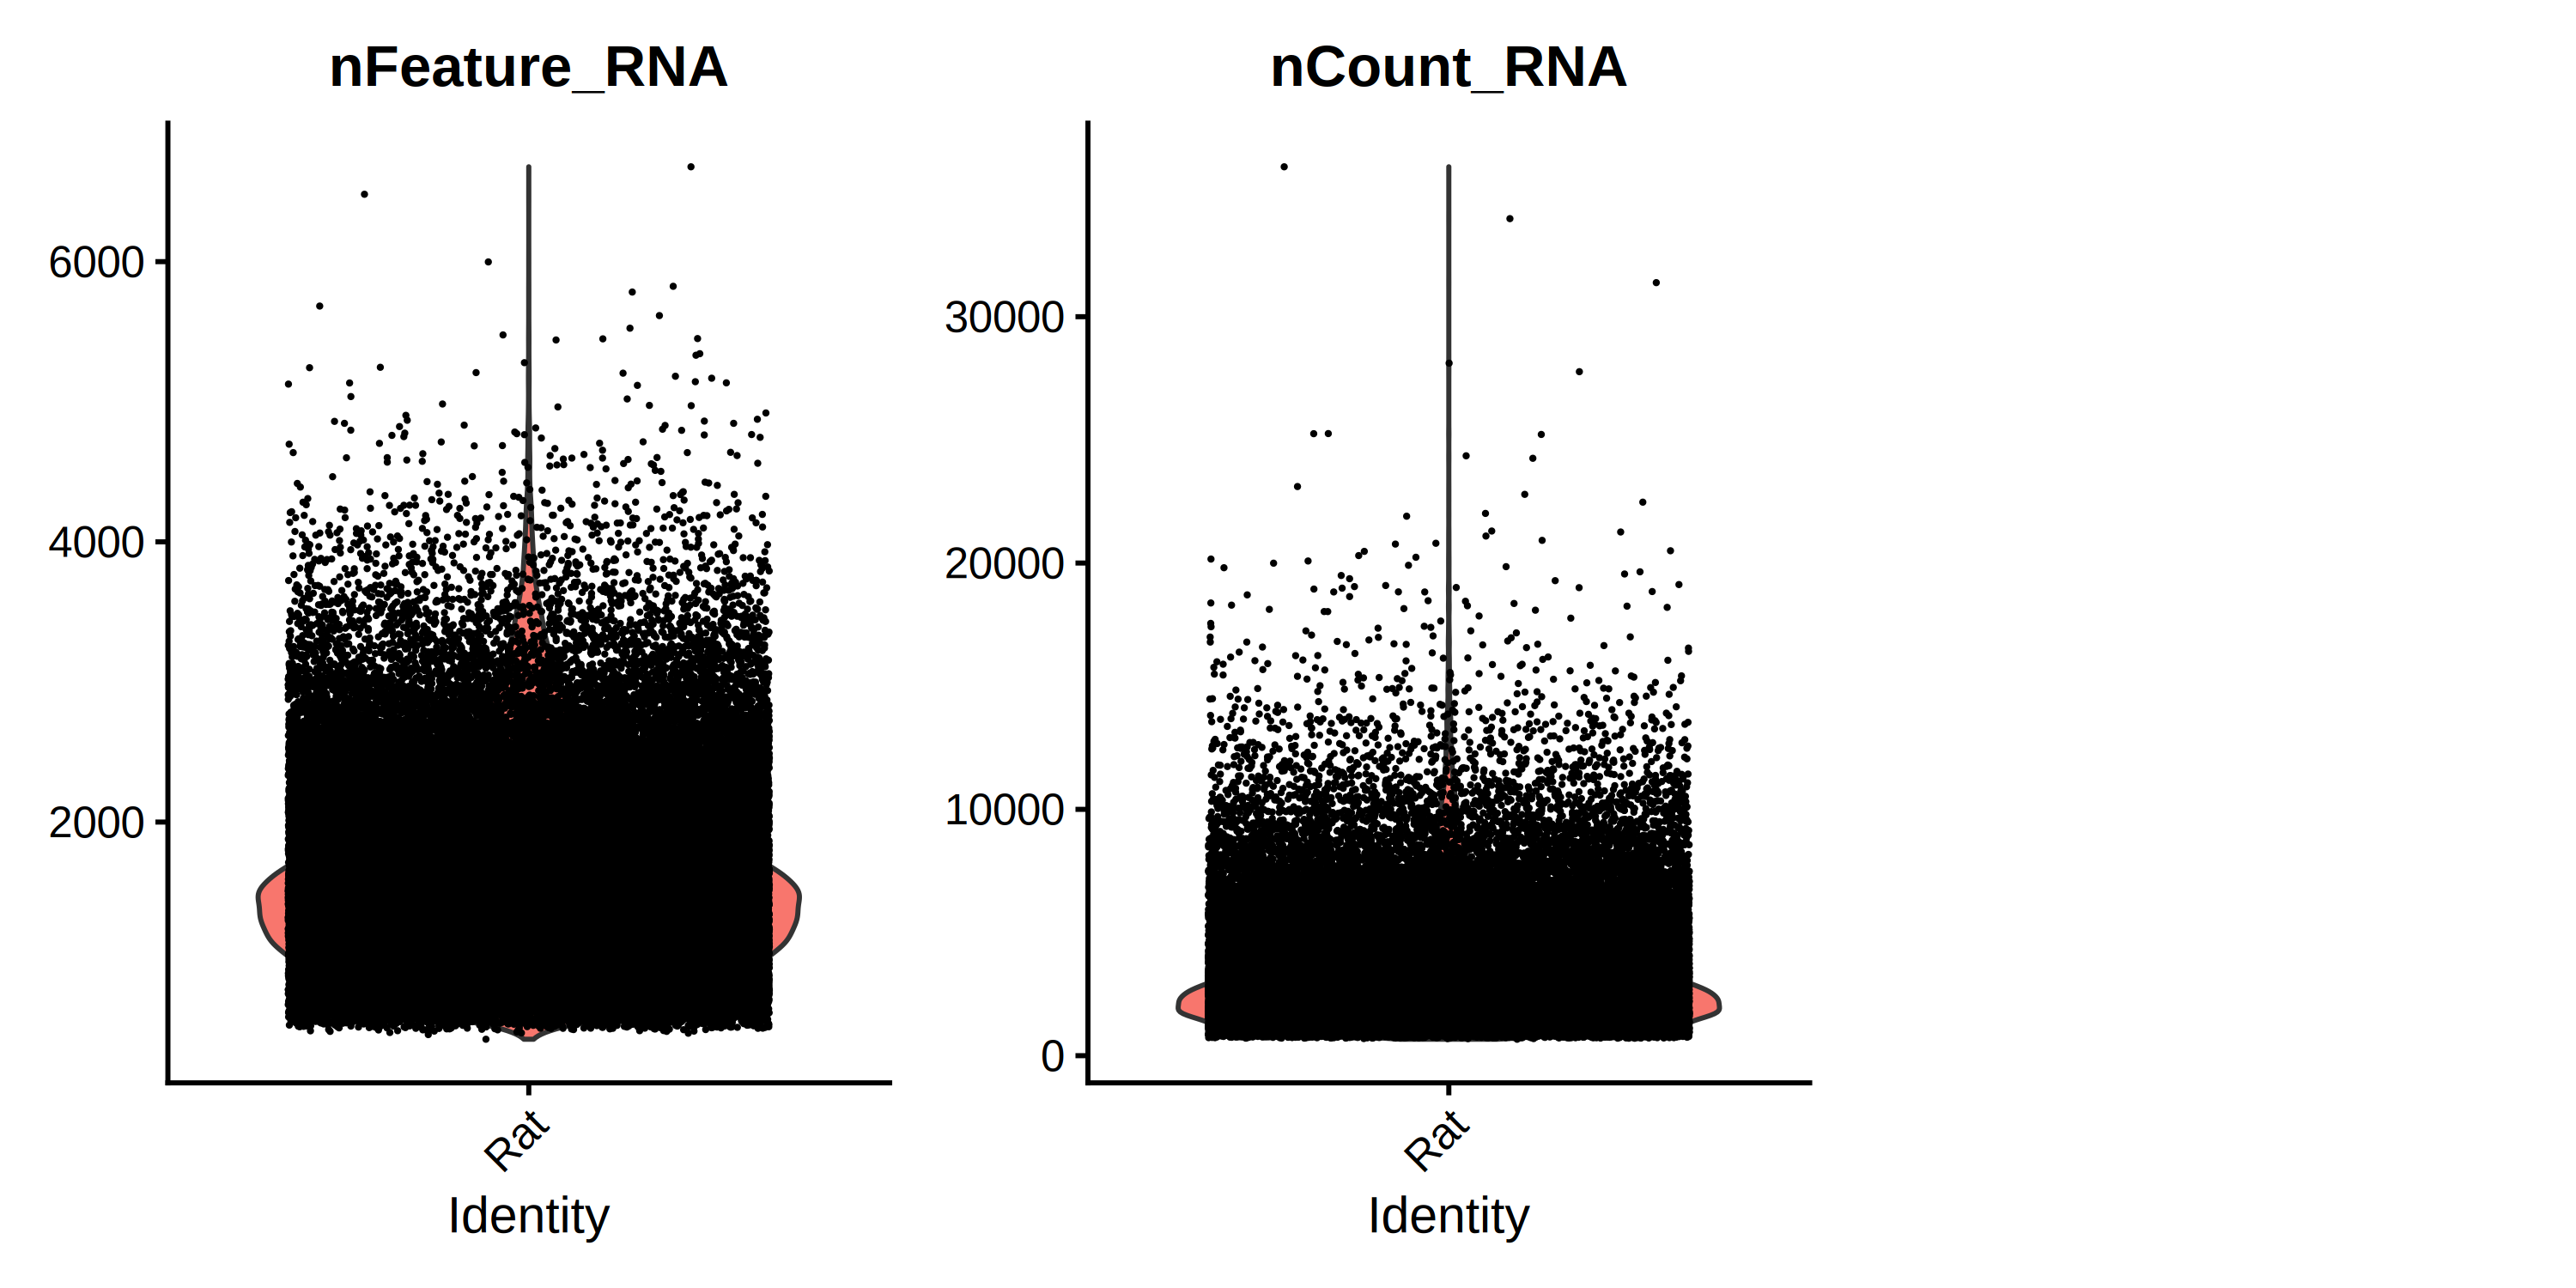

In [10]:
p1

In [11]:
## filter cells with detected gene number between 200 and 4000
obj <- subset(Seurat_merged, subset = nFeature_RNA > 200 & nFeature_RNA < 4000)

In [12]:
obj

An object of class Seurat 
26597 features across 76089 samples within 1 assay 
Active assay: RNA (26597 features, 0 variable features)
 1 layer present: counts

## Normalizing the data

In [13]:
## using SCTransform to normalize the gene counts
obj <- SCTransform(obj, vst.flavor = 'v2', verbose = FALSE) 

In [14]:
## Run PCA dimention reduction on the normalized counts
obj <- obj %>%
    RunPCA(npcs = 30, verbose = FALSE,features = VariableFeatures(object = obj))

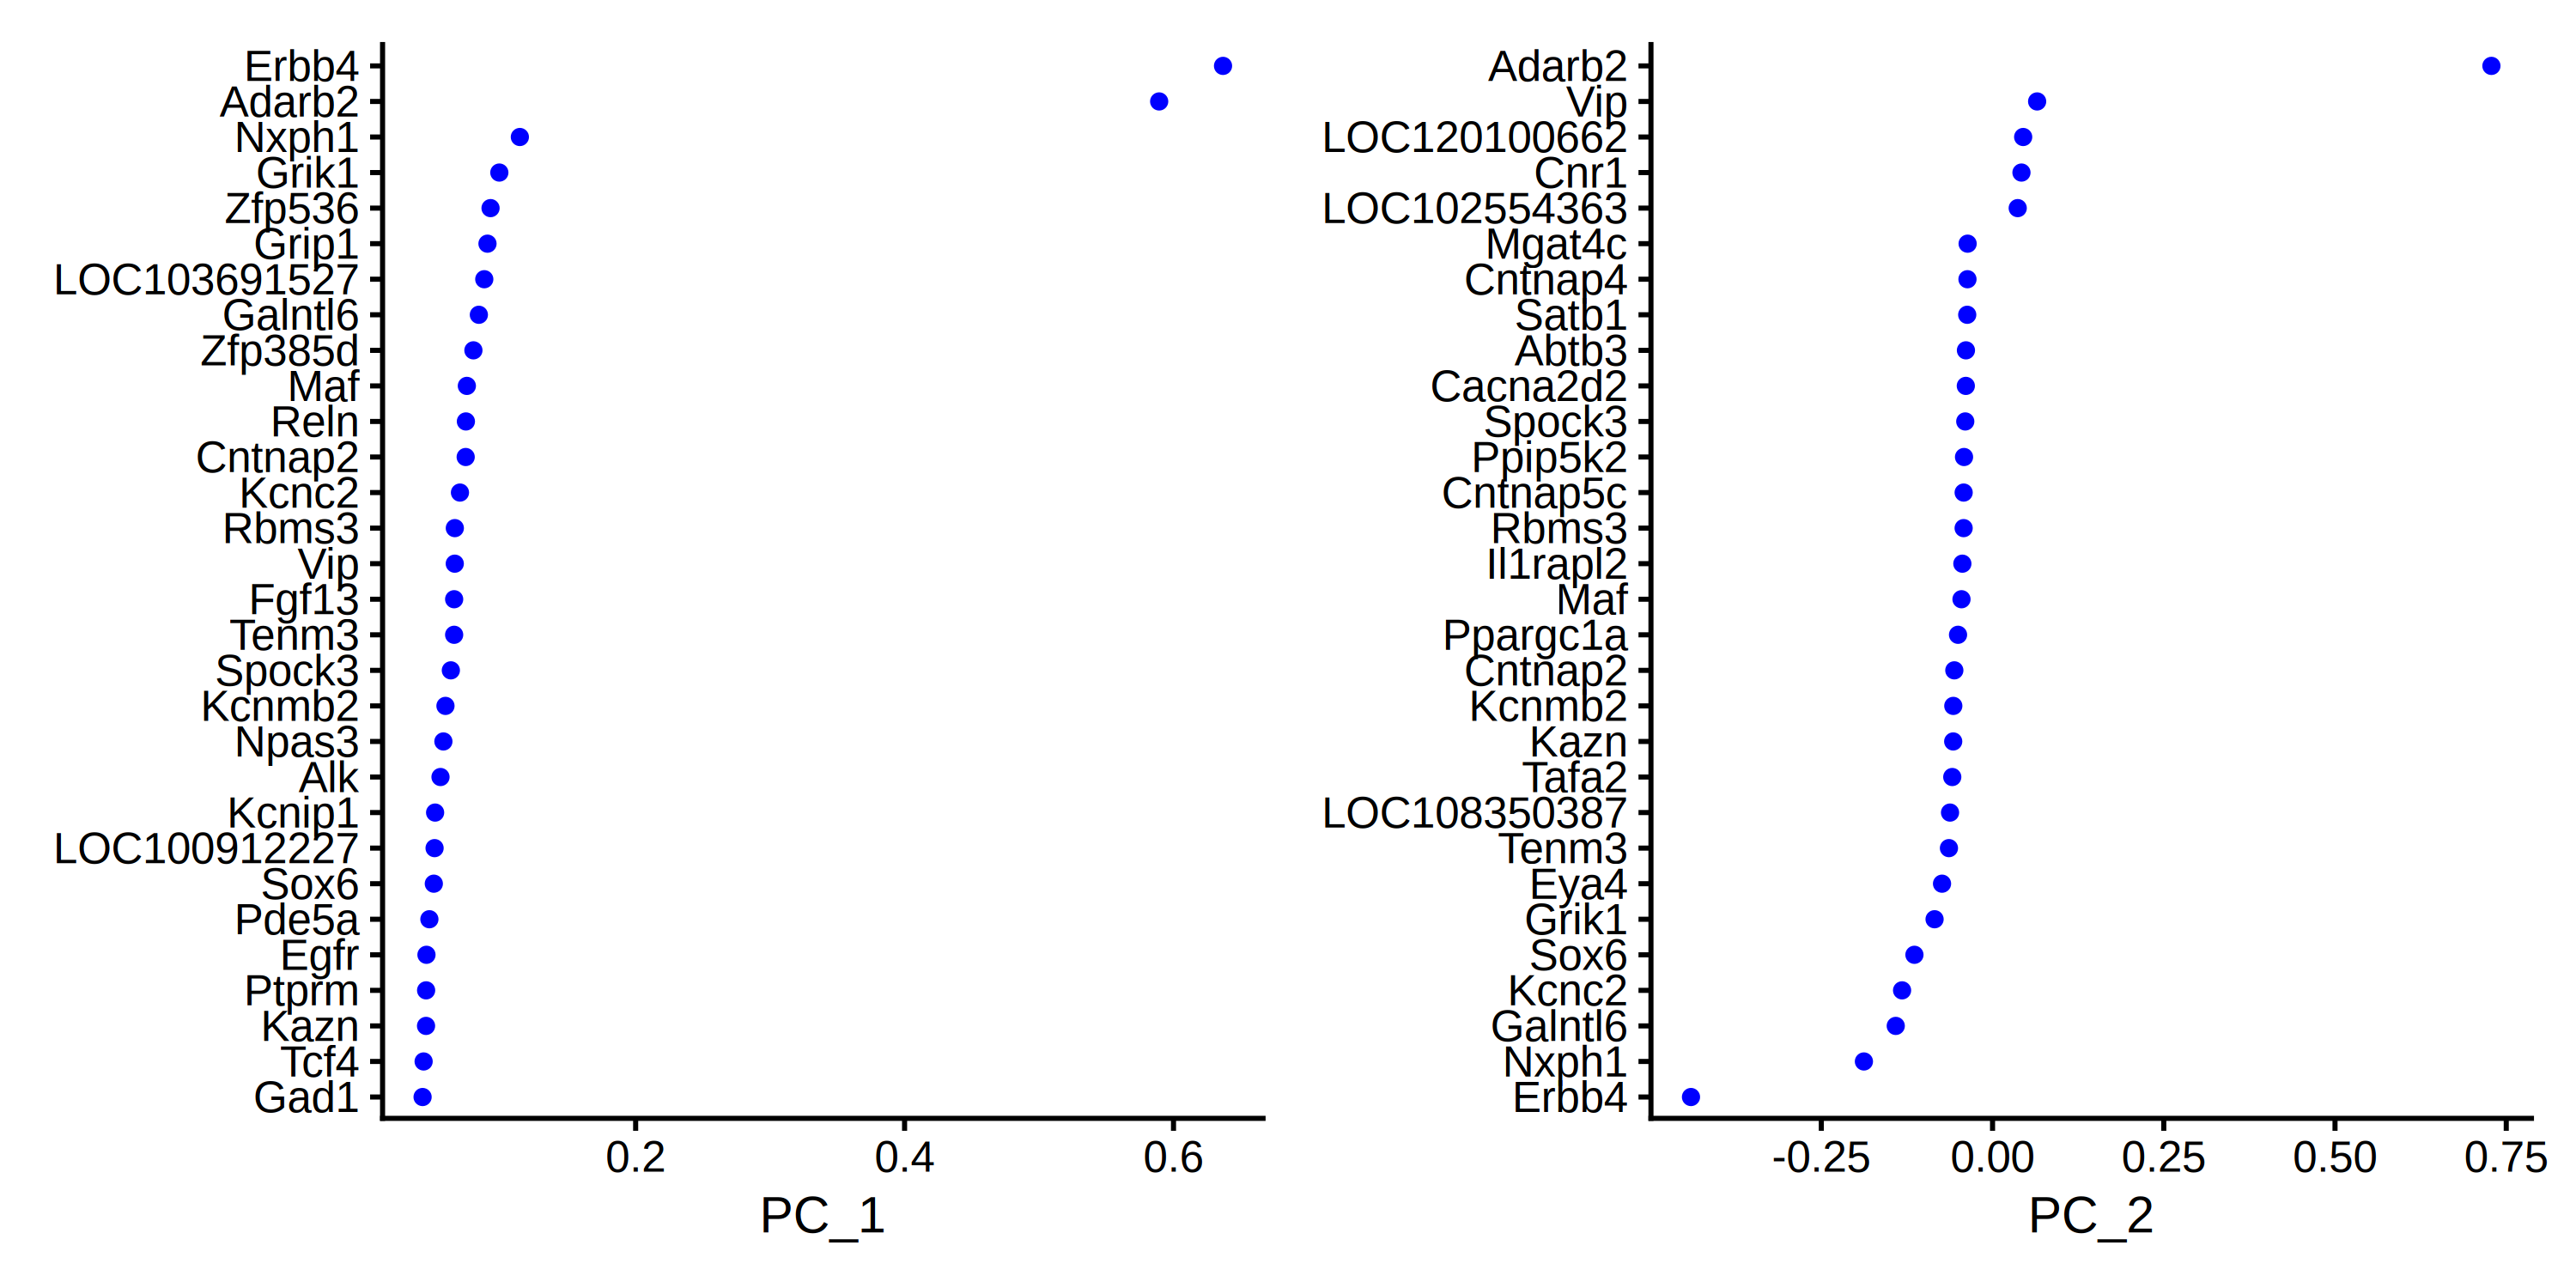

In [15]:
VizDimLoadings(obj, dims = 1:2, reduction = "pca")

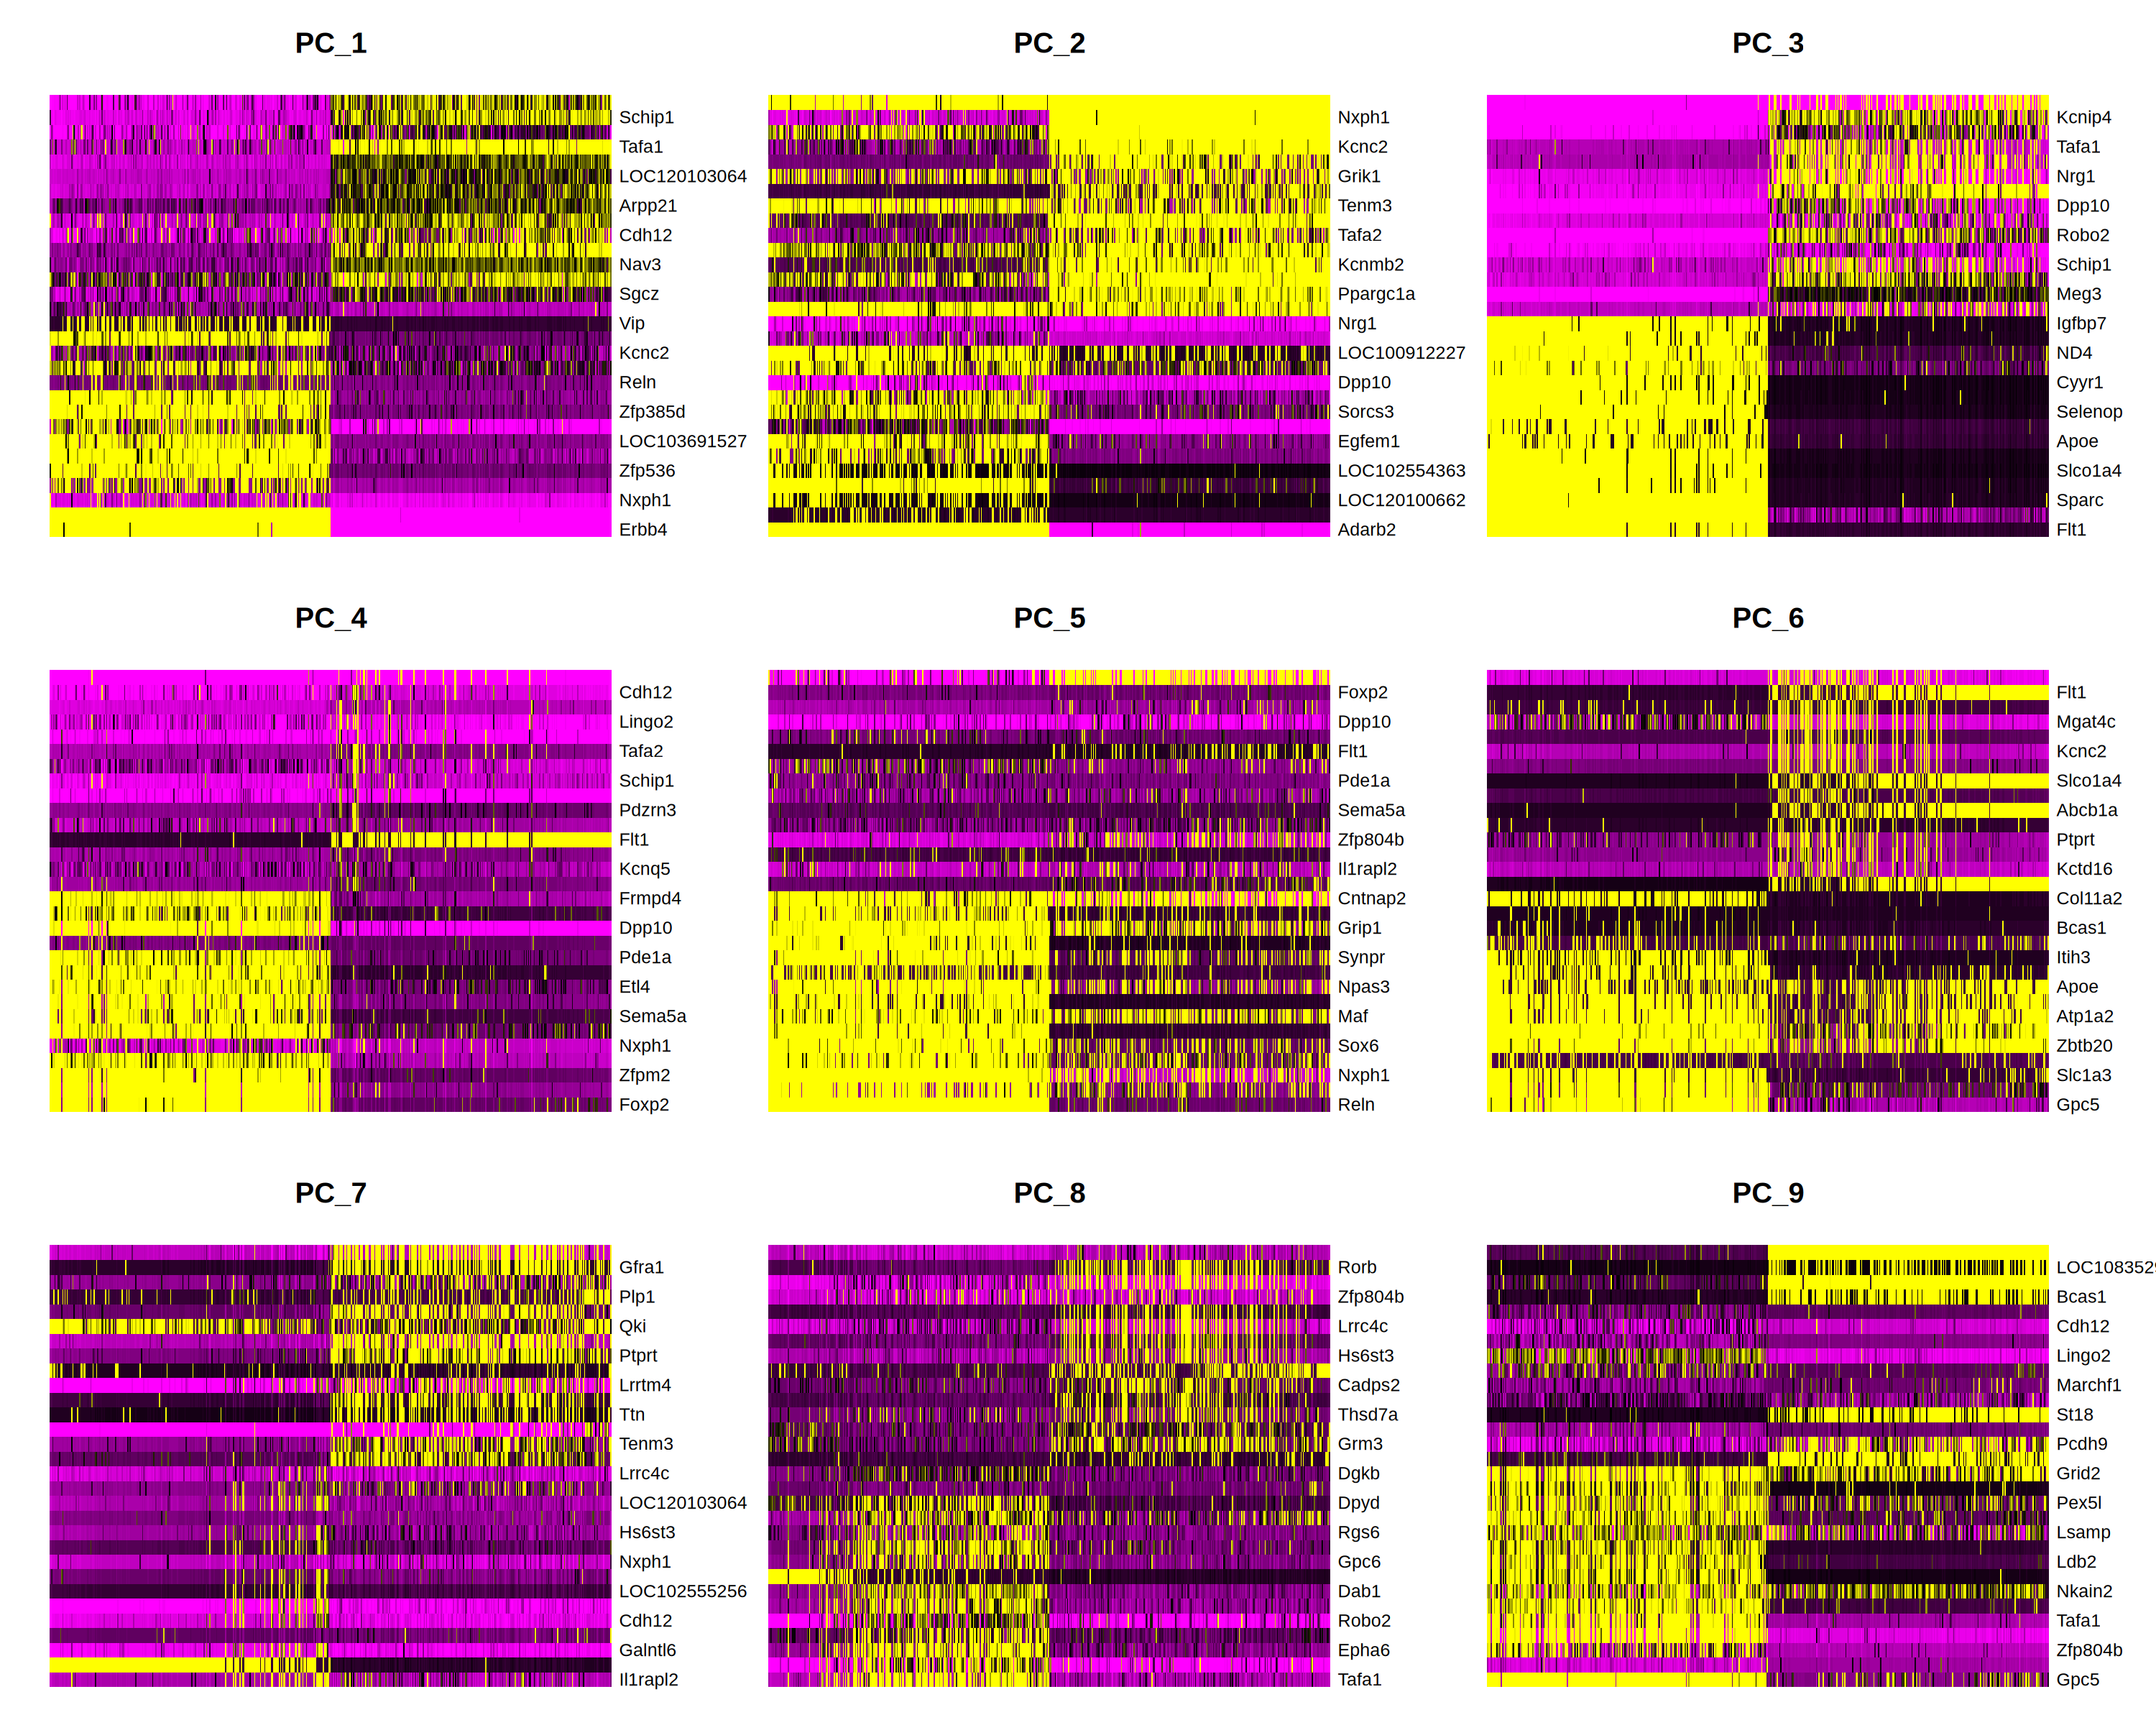

In [16]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)
DimHeatmap(obj, dims = 1:9, cells = 500, balanced = TRUE)

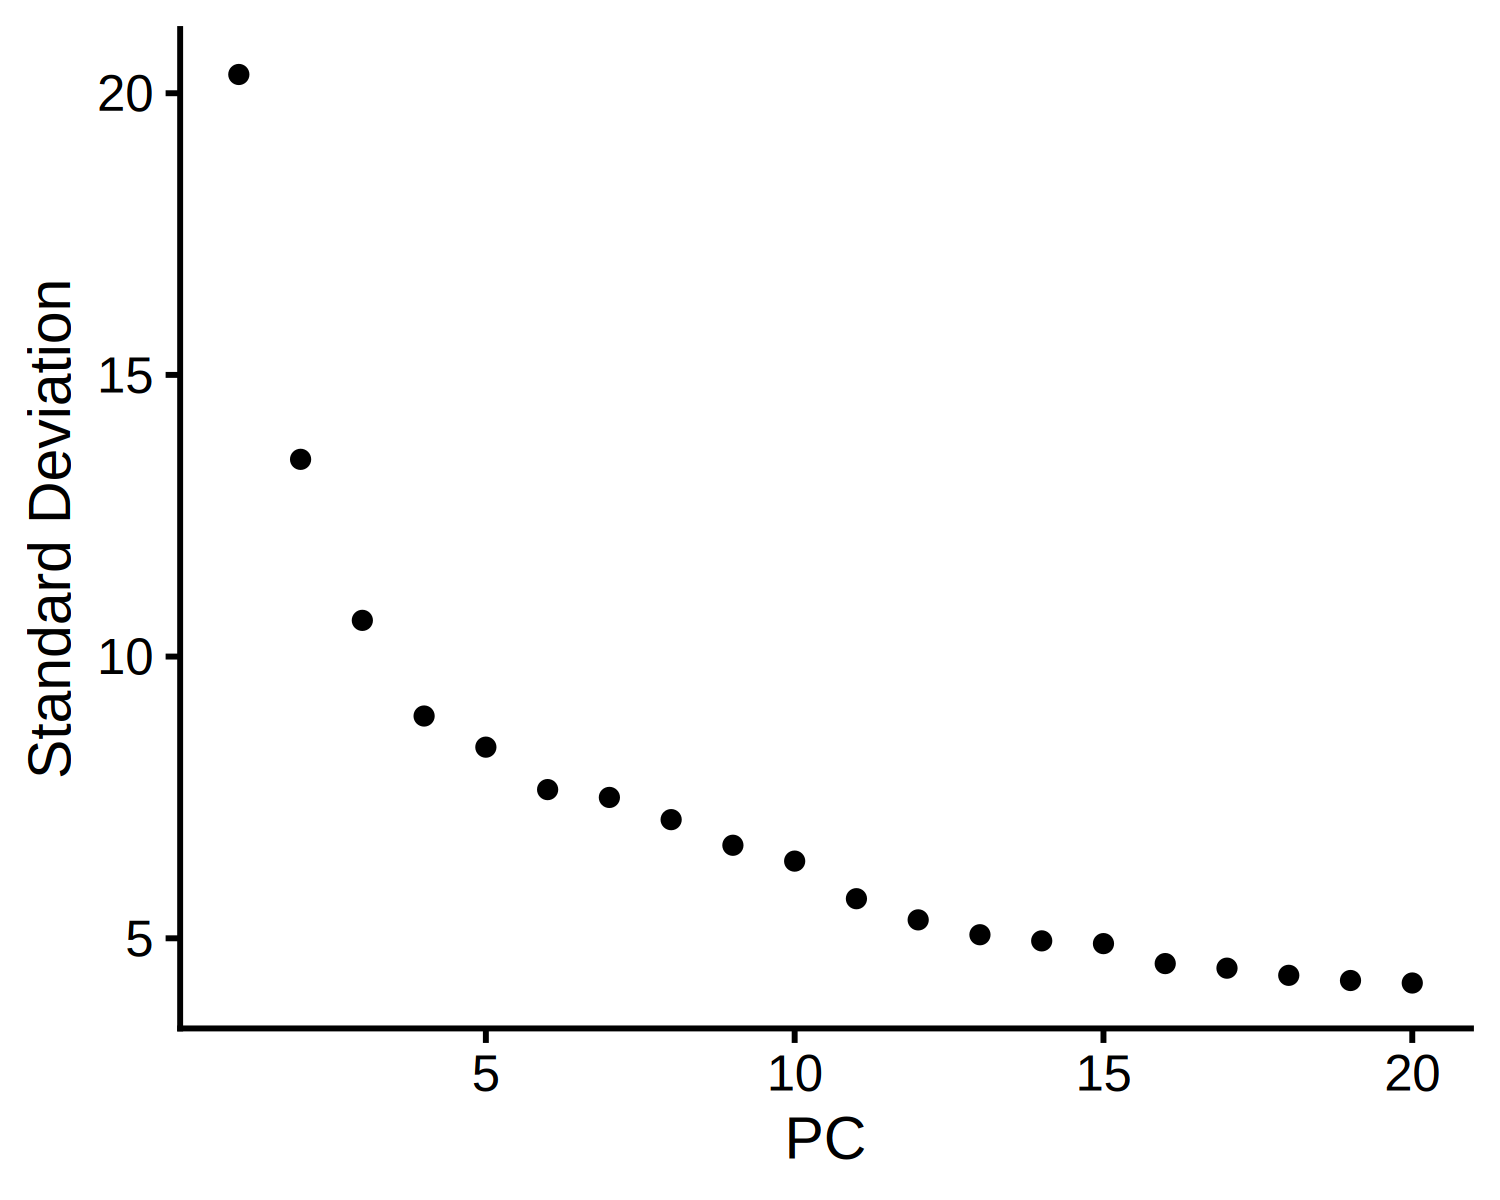

In [17]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 300)
ElbowPlot(obj)

##  cell clustering 

In [18]:
obj

An object of class Seurat 
52115 features across 76089 samples within 2 assays 
Active assay: SCT (25518 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

In [19]:
## add the group and sex information of each cell in the metadata
obj <- AddMetaData(
  object = obj,
  metadata = stringr::str_split(row.names(obj@meta.data),"-",simplify=T)[,1],
  col.name = 'group'
)

obj <- AddMetaData(
  object = obj,
  metadata = stringr::str_split(row.names(obj@meta.data),"-",simplify=T)[,2],
  col.name = 'sex'
)

In [20]:
head(obj@meta.data)

orig.ident nCount_RNA nFeature_RNA
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA Rat        2892       1519        
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG Rat        2971       1489        
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG Rat        1996       1189        
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT Rat        5871       2496        
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG Rat        2068       1185        
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT Rat        1922       1121        
                                       percent.mt nCount_SCT nFeature_SCT group
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA 0          3229       1519         iso  
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG 0          3287       1489         iso  
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG 0          3028       1208         iso  
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT 0          4299       2456         iso  
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG 0          3104       1190         iso  
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT 0          3064       1153         iso  
                                       sex
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA F  
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG F  
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG F  
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT F  
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG F  
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT F

In [ ]:
## run cell clustering with the first 15 PCs
obj <- obj %>%
        FindNeighbors(reduction = "pca", dims = 1:15, verbose = FALSE) %>%
        FindClusters(resolution = 0.7, verbose = FALSE) %>%
        RunUMAP(reduction = "pca", dims = 1:15, verbose = FALSE)

In [22]:
obj

An object of class Seurat 
52115 features across 76089 samples within 2 assays 
Active assay: SCT (25518 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

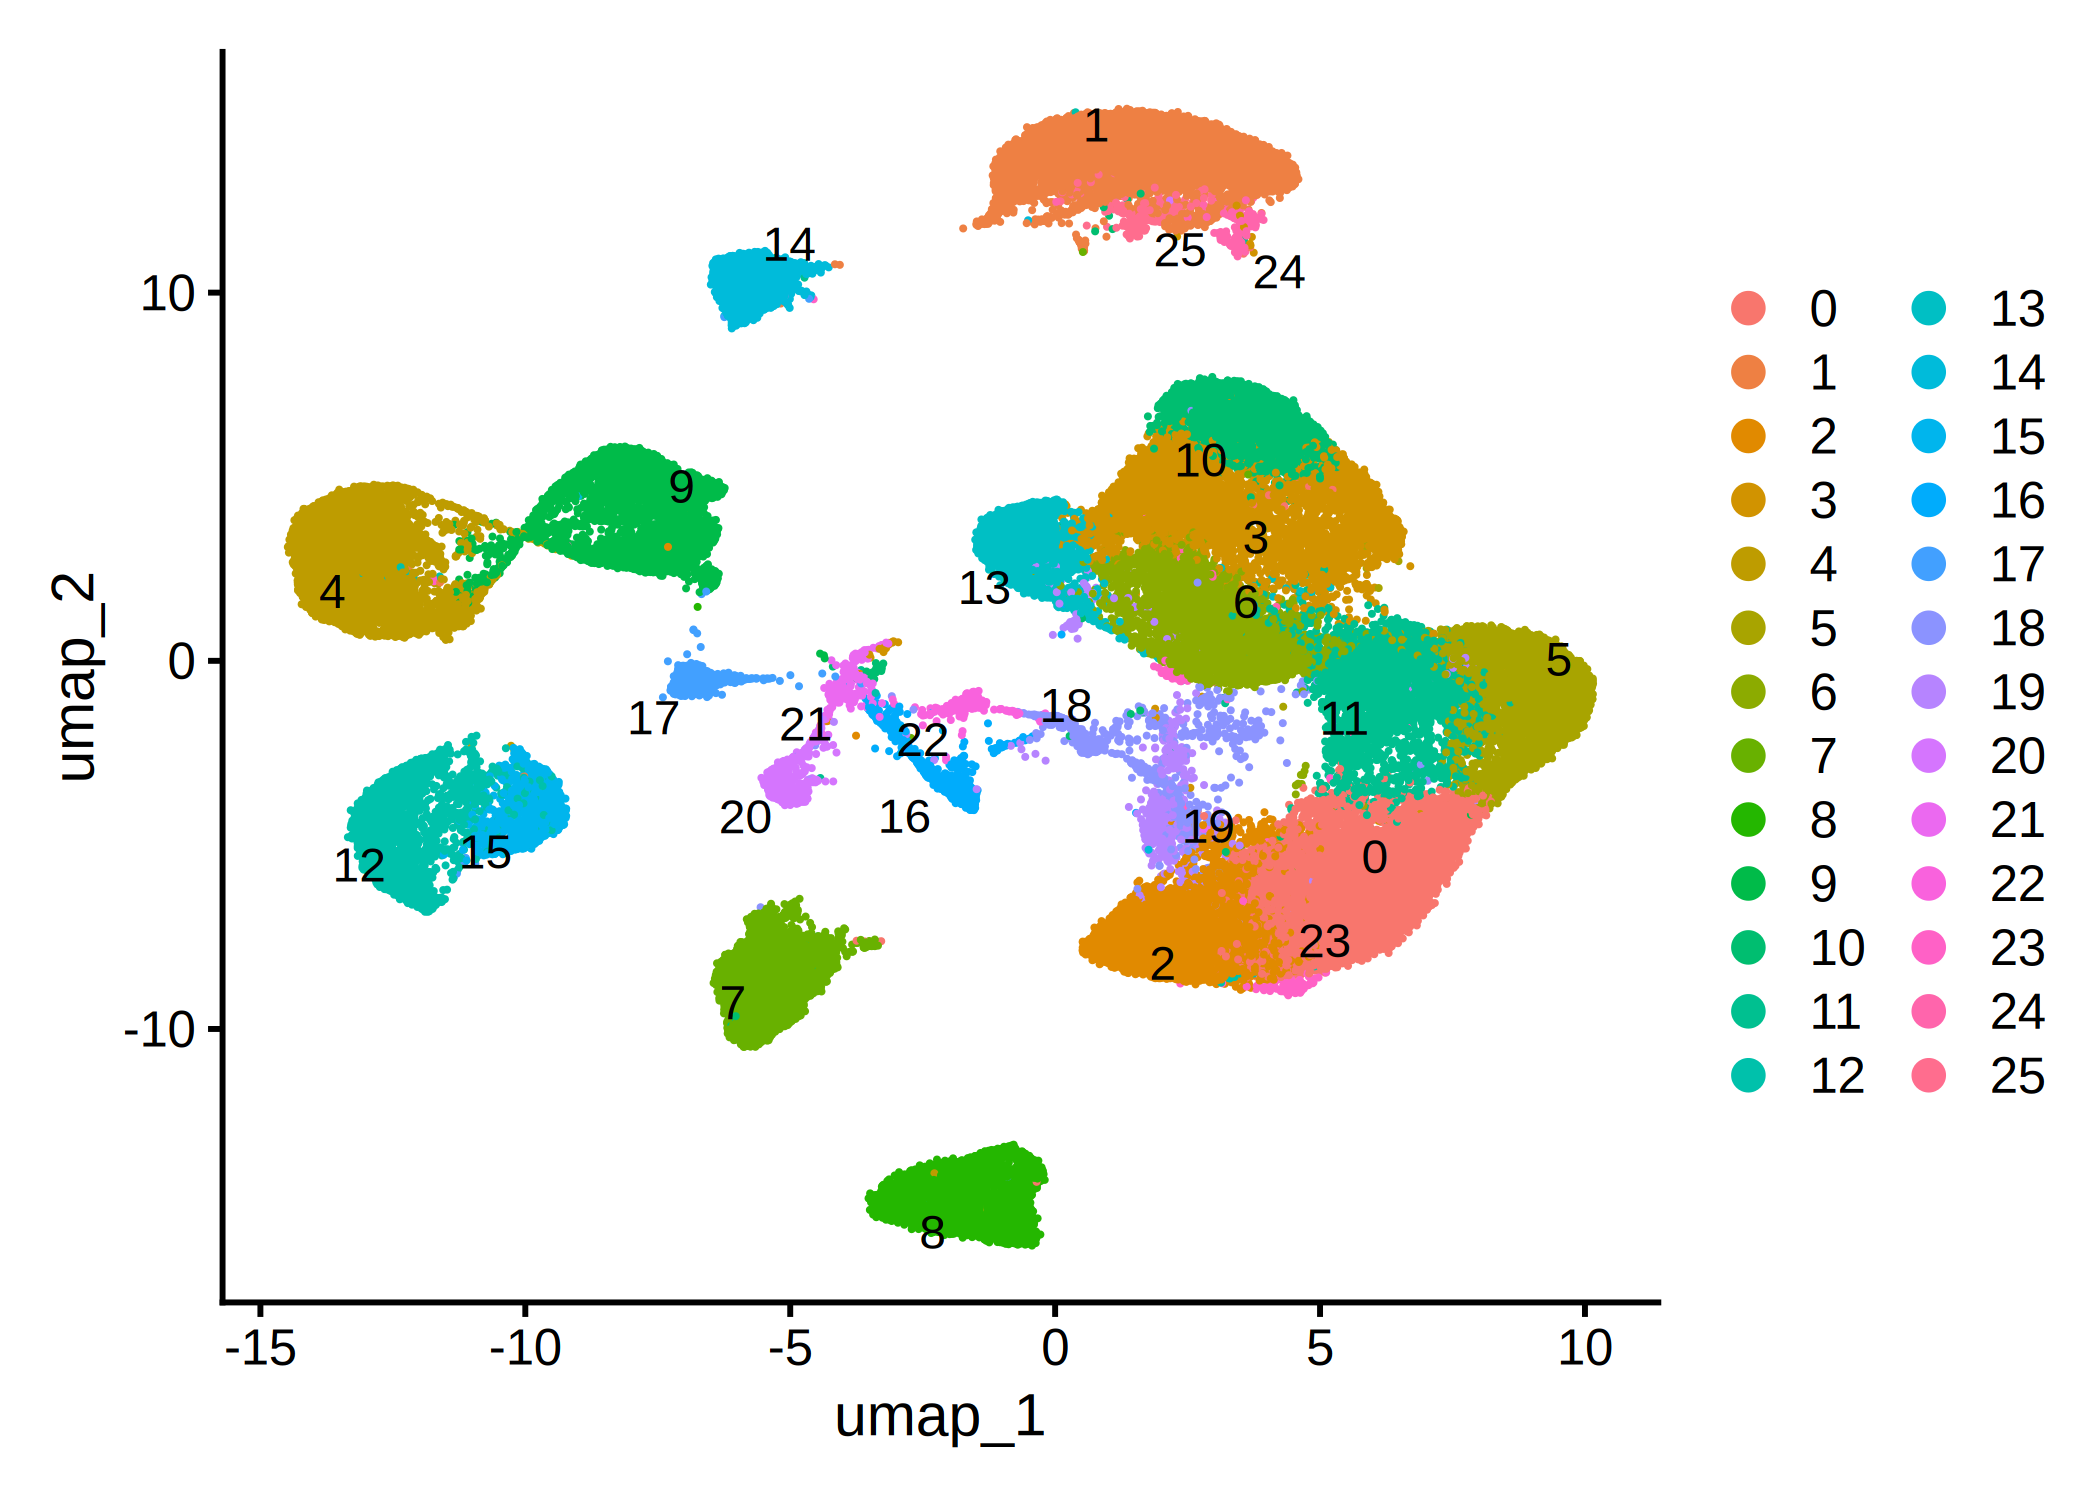

In [23]:
## umap plot
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 300)
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(obj, reduction = "umap",label = TRUE, repel = TRUE)

## define doublet

remove the doublets with DoubleFinder

In [ ]:
library('DoubletFinder')

homotypic.prop <- modelHomotypic(obj@meta.data$seurat_clusters)           ## ex: annotations <- seu_kidney@meta.data$ClusteringResults
nExp_poi <- round(0.075*nrow(obj@meta.data))  ## Assuming 7.5% doublet formation rate - tailor for your dataset
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))

## Run DoubletFinder with varying classification stringencies ----------------------------------------------------------------
seu_obj <- doubletFinder(obj, PCs = 1:10, pN = 0.25, pK = 0.09, nExp = nExp_poi, reuse.pANN = FALSE, sct = TRUE)

In [25]:
head(seu_obj@meta.data)

orig.ident nCount_RNA nFeature_RNA
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA Rat        2892       1519        
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG Rat        2971       1489        
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG Rat        1996       1189        
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT Rat        5871       2496        
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG Rat        2068       1185        
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT Rat        1922       1121        
                                       percent.mt nCount_SCT nFeature_SCT group
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA 0          3229       1519         iso  
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG 0          3287       1489         iso  
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG 0          3028       1208         iso  
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT 0          4299       2456         iso  
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG 0          3104       1190         iso  
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT 0          3064       1153         iso  
                                       sex SCT_snn_res.0.7 seurat_clusters
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA F   9               9              
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG F   10              10             
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG F   9               9              
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT F   14              14             
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG F   5               5              
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT F   9               9              
                                       pANN_0.25_0.09_5707
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA 0.3220896          
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG 0.2795970          
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG 0.3189136          
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT 0.2988720          
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG 0.1328442          
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT 0.3220896          
                                       DF.classifications_0.25_0.09_5707
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA Singlet                          
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG Singlet                          
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG Singlet                          
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT Singlet                          
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG Singlet                          
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT Singlet

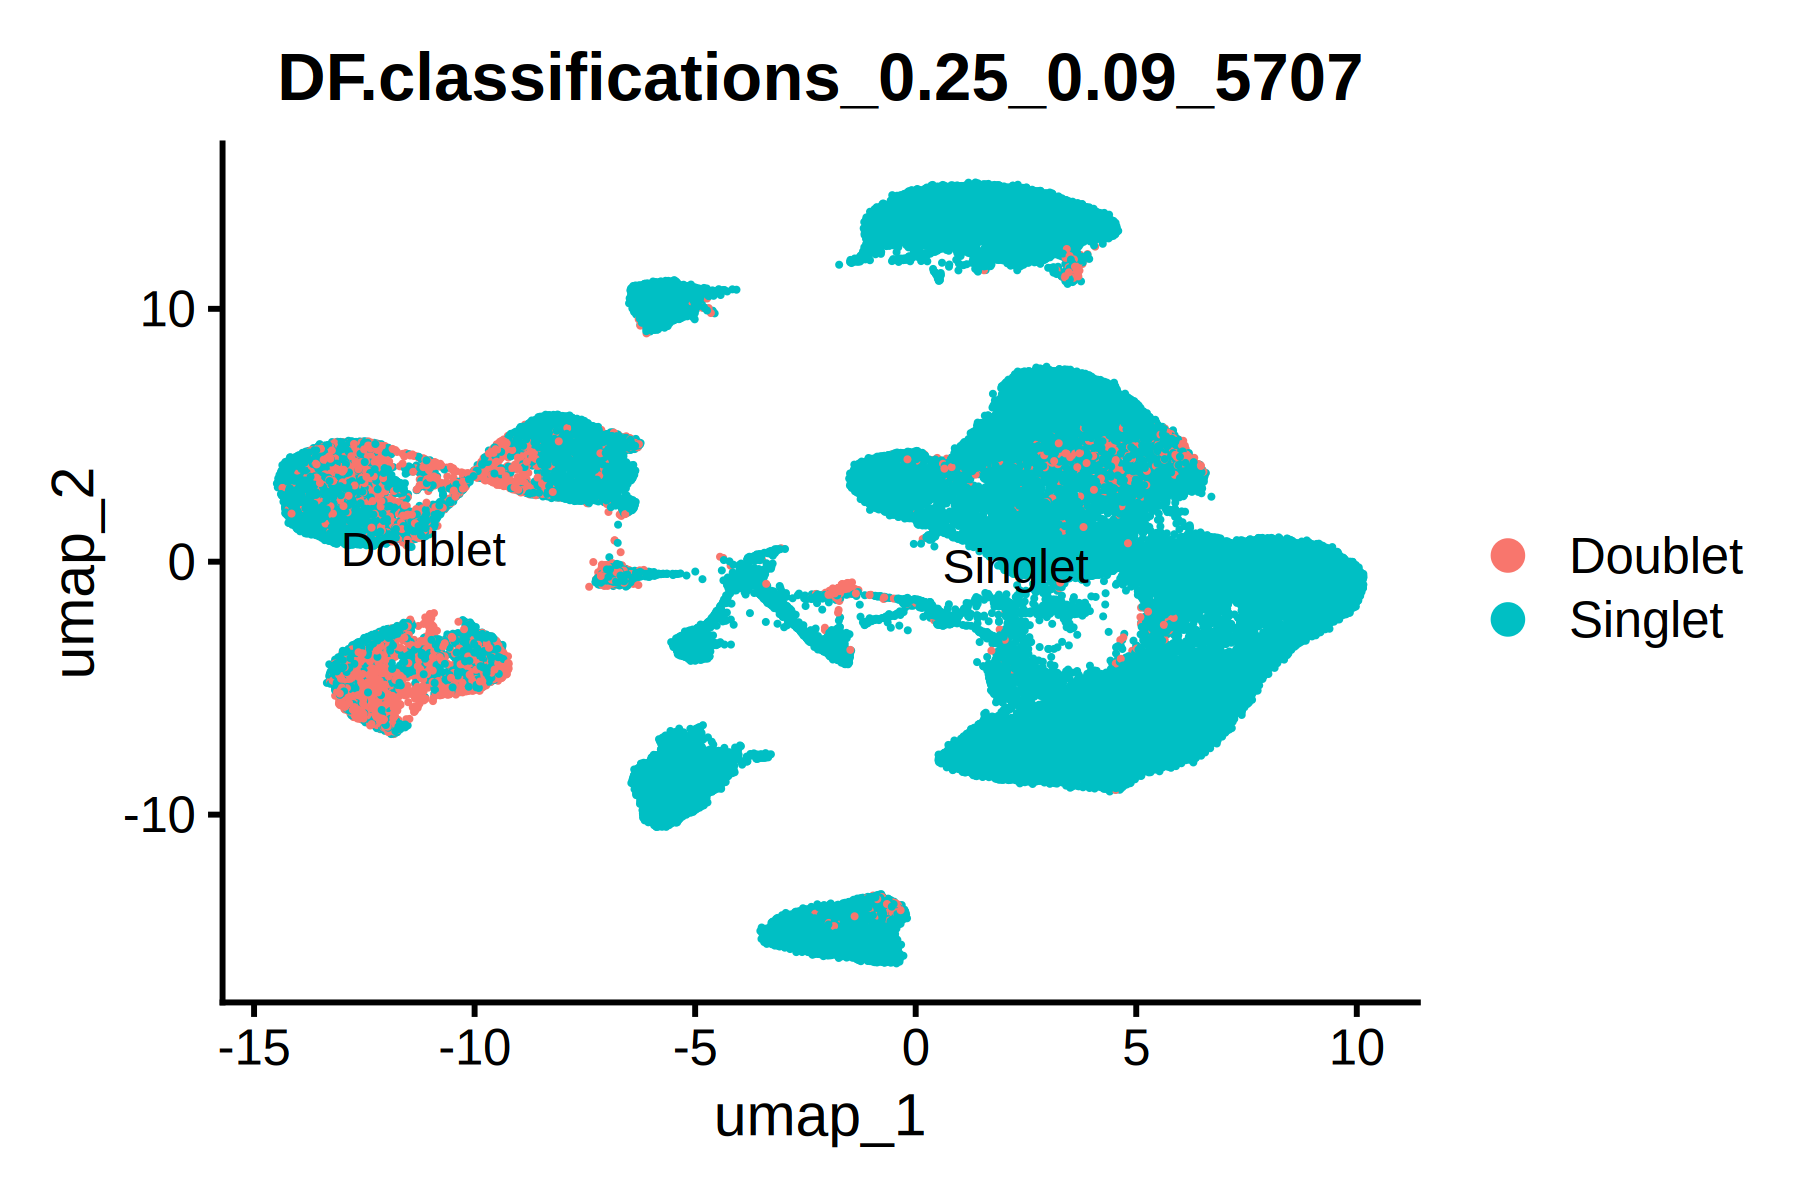

In [27]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(seu_obj, reduction = "umap",label = TRUE, group.by = "DF.classifications_0.25_0.09_5707")

In [30]:
seu_obj <- subset(x = seu_obj, subset = DF.classifications_0.25_0.09_5707=="Singlet")

In [31]:
seu_obj

An object of class Seurat 
52115 features across 70382 samples within 2 assays 
Active assay: SCT (25518 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

### reclustering on the filtered cells

In [ ]:
seu_obj <- seu_obj %>%
        FindNeighbors(reduction = "pca", dims = 1:15, verbose = FALSE) %>%
        FindClusters(resolution = 0.7, verbose = FALSE) %>%
        RunUMAP(reduction = "pca", dims = 1:15, verbose = FALSE)

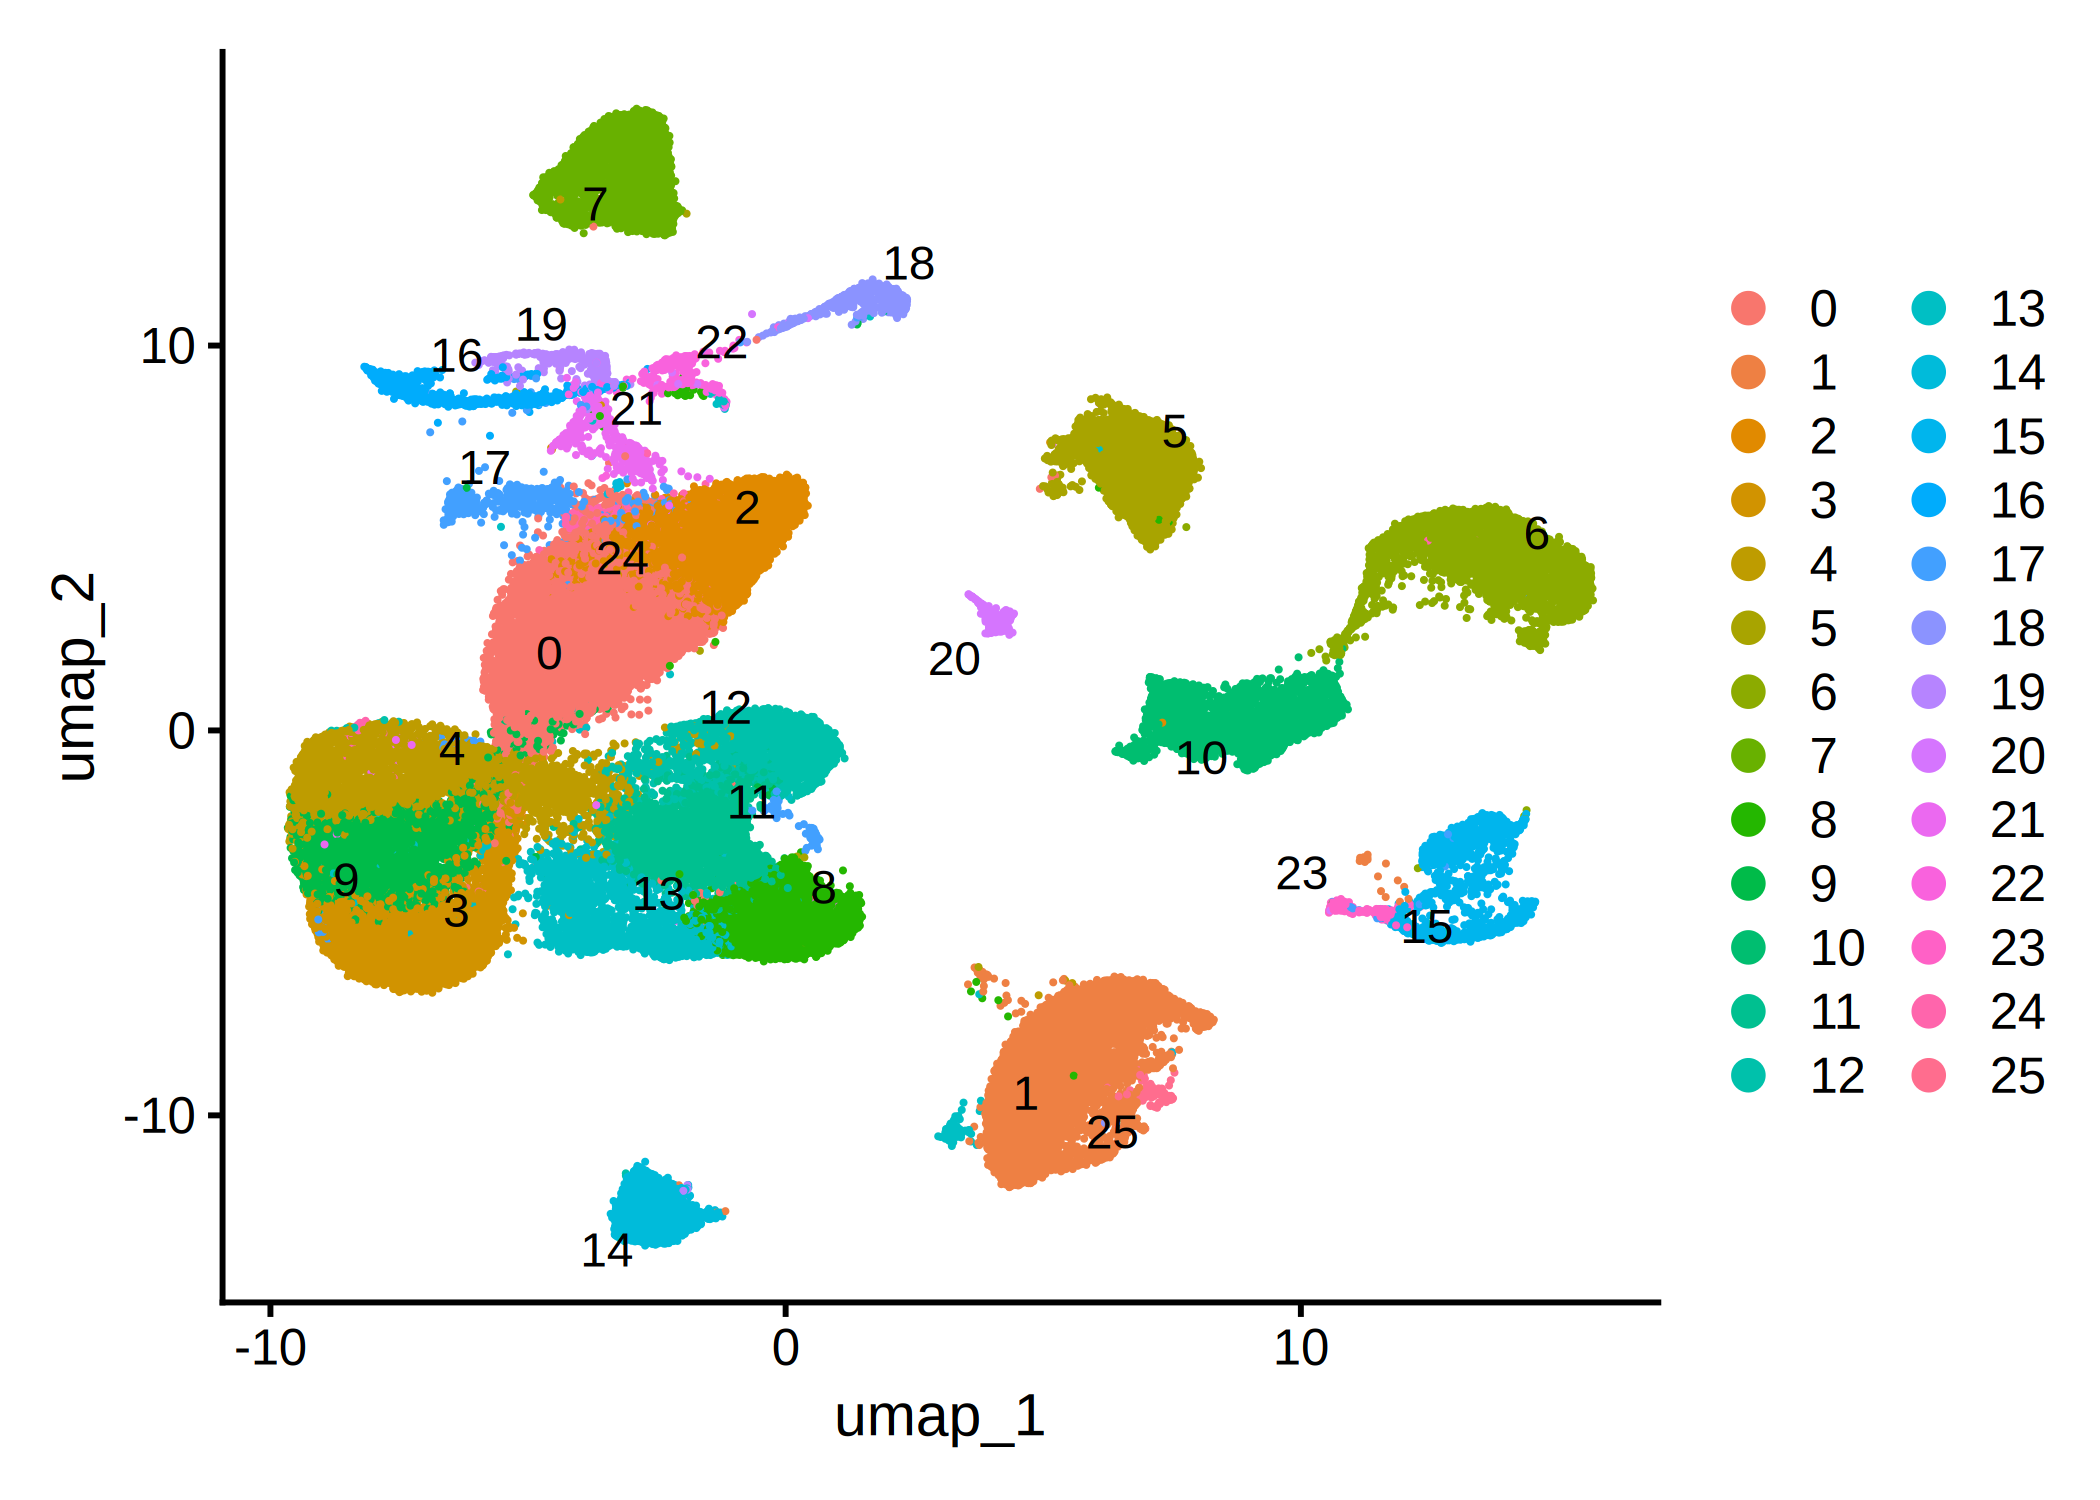

In [33]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 300)
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(seu_obj, reduction = "umap",label = TRUE, repel = TRUE)

In [36]:
library(dplyr)
library(stringr)

In [37]:
head(seu_obj@meta.data)

orig.ident nCount_RNA nFeature_RNA
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA Rat        2892       1519        
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG Rat        2971       1489        
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG Rat        1996       1189        
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT Rat        5871       2496        
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG Rat        2068       1185        
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT Rat        1922       1121        
                                       percent.mt nCount_SCT nFeature_SCT group
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA 0          3229       1519         iso  
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG 0          3287       1489         iso  
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG 0          3028       1208         iso  
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT 0          4299       2456         iso  
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG 0          3104       1190         iso  
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT 0          3064       1153         iso  
                                       sex SCT_snn_res.0.7 seurat_clusters
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA F   10              10             
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG F   8               8              
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG F   10              10             
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT F   14              14             
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG F   3               3              
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT F   10              10             
                                       pANN_0.25_0.09_5707
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA 0.3220896          
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG 0.2795970          
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG 0.3189136          
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT 0.2988720          
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG 0.1328442          
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT 0.3220896          
                                       DF.classifications_0.25_0.09_5707
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA Singlet                          
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG Singlet                          
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG Singlet                          
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT Singlet                          
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG Singlet                          
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT Singlet

Add substitutional sample name to metadata

In [39]:
seu_obj@meta.data$sampleID <- str_split(row.names(seu_obj@meta.data),"_",simplify = T)[,1]
seu_obj@meta.data <- 
    seu_obj@meta.data %>%
    mutate(sample_name = case_when(sampleID == "iso-F-04" ~ "iso-F_1",
                                   sampleID == "iso-F-22" ~ "iso-F_2",
                                   sampleID == "iso-F-35" ~ "iso-F_3",
                                   sampleID == "iso-M-00" ~ "iso-M_1",
                                   sampleID == "iso-M-23" ~ "iso-M_2",
                                   sampleID == "iso-M-40" ~ "iso-M_3",
                                   sampleID == "soc-F-05" ~ "soc-F_1",
                                   sampleID == "soc-F-24" ~ "soc-F_2",
                                   sampleID == "soc-F-36" ~ "soc-F_3",
                                   sampleID == "soc-M-01" ~ "soc-M_1",
                                   sampleID == "soc-M-25" ~ "soc-M_2",
                                   sampleID == "soc-M-41" ~ "soc-M_3"
                                  ))


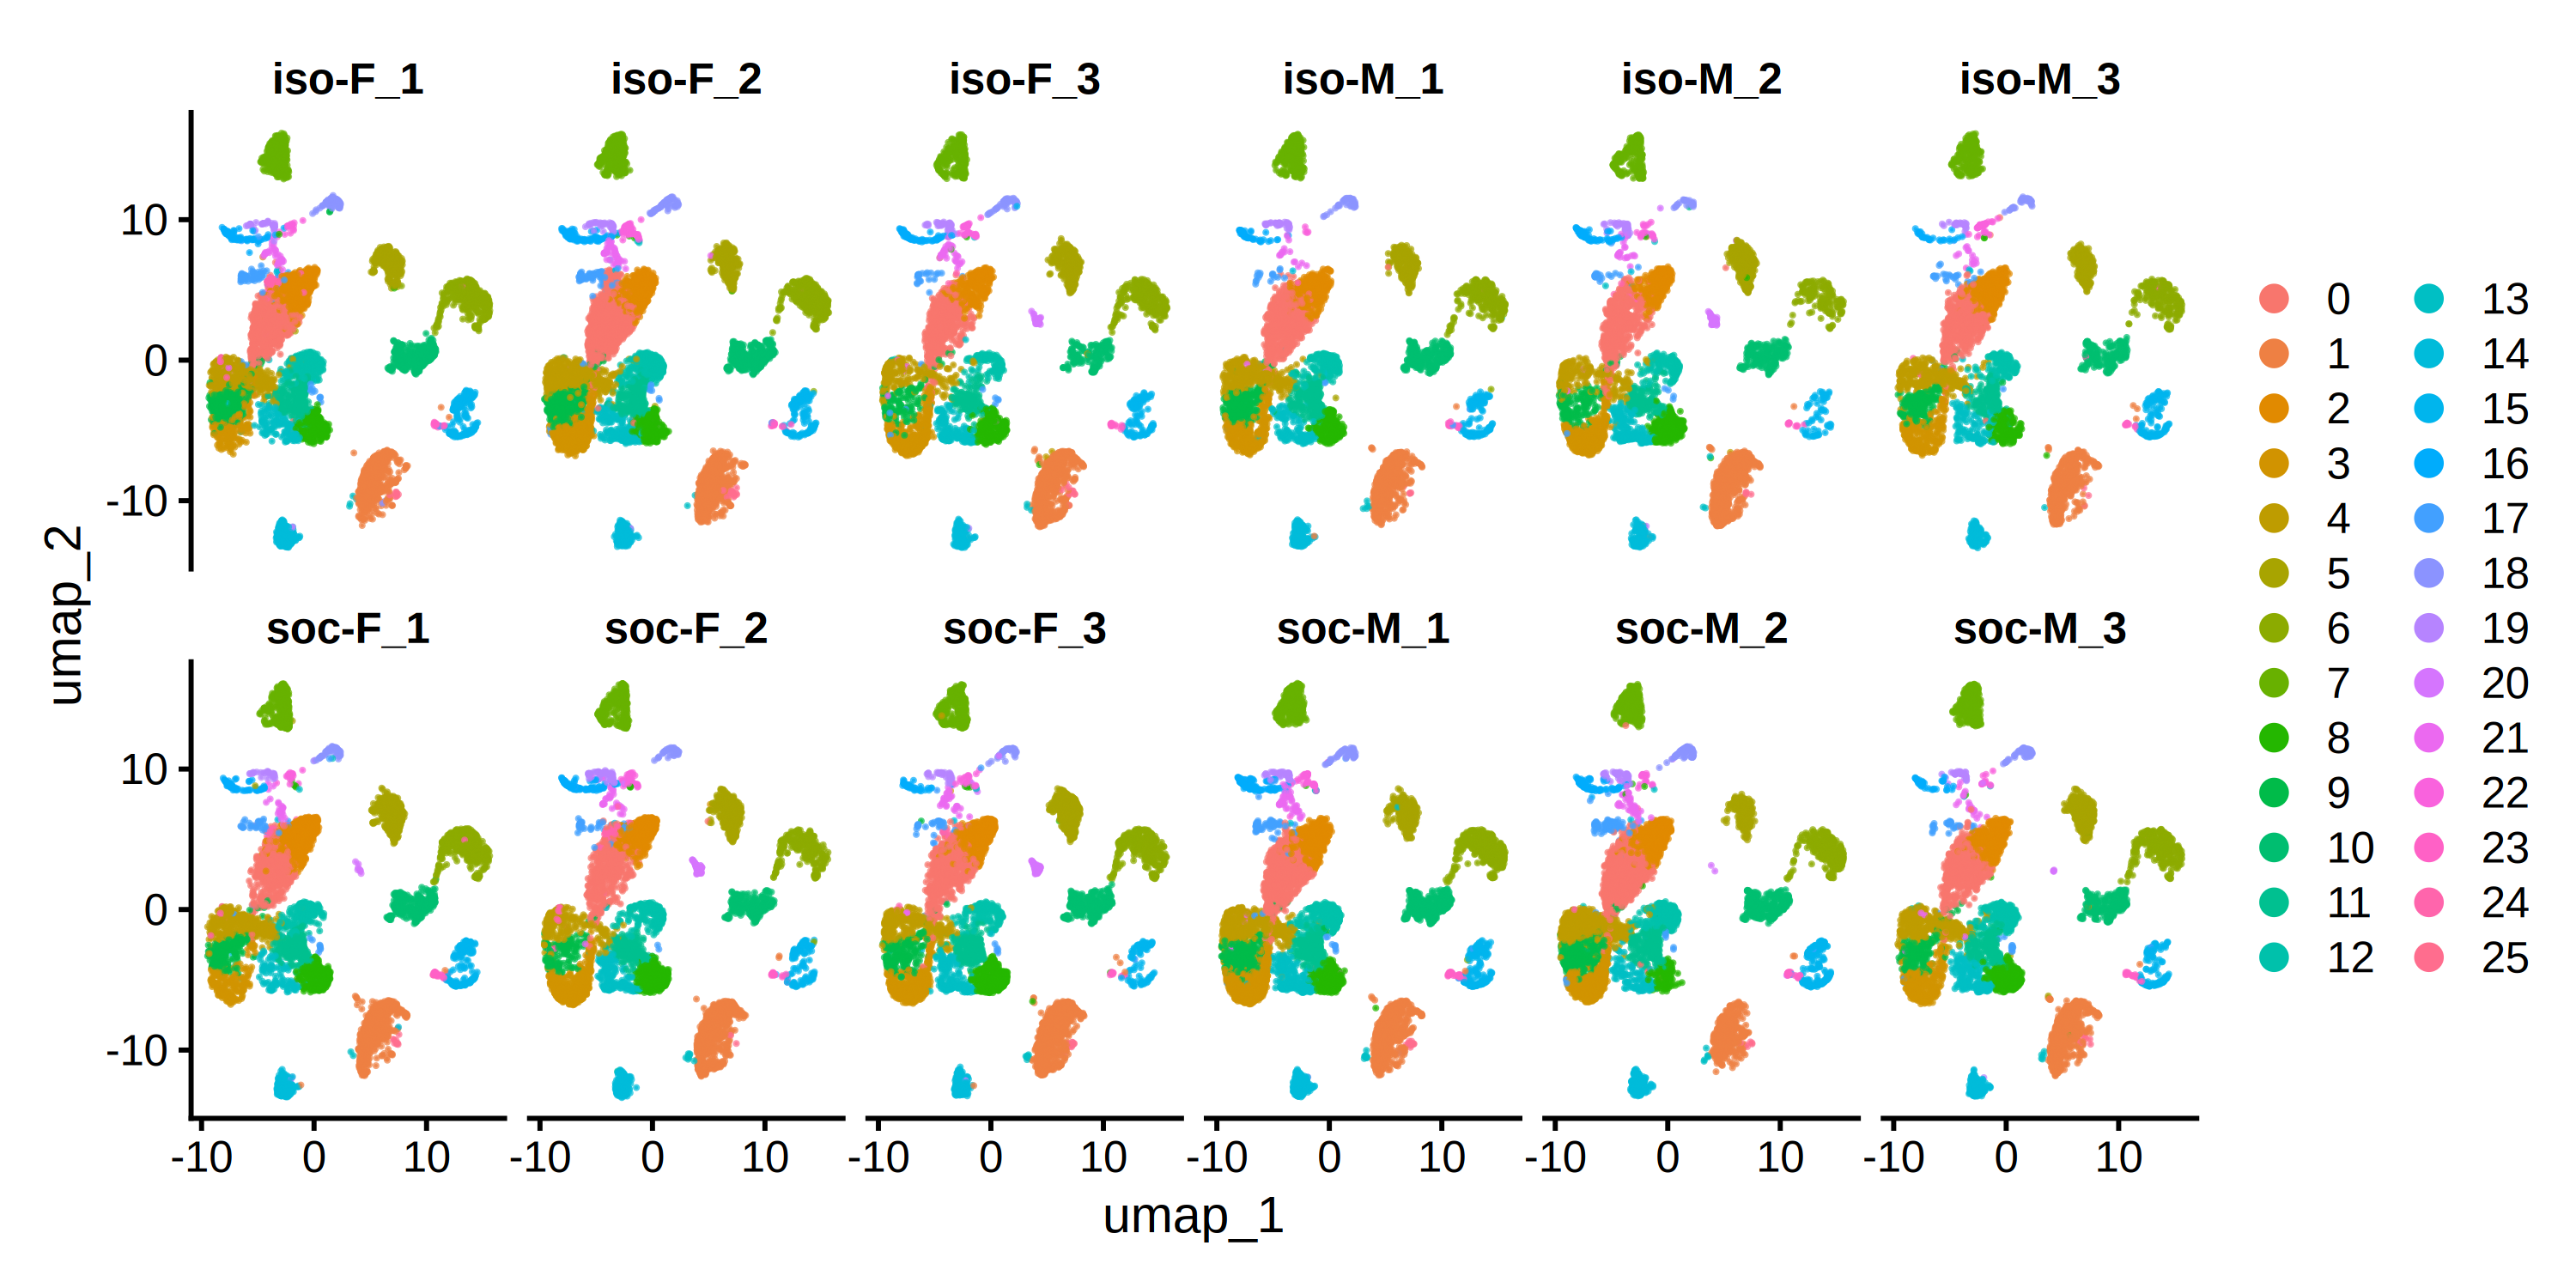

In [40]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)
DimPlot(seu_obj, reduction = "umap", split.by = "sample_name",alpha=0.7,ncol=6)

In [41]:
saveRDS(seu_obj,file="/project/zhuzhuzhang/lyang/scaleBio_RNA_rat_brain/out_mRatBN/merged_seurat_obj_DF_removed_2.rds")

In [3]:
head(seu_obj@meta.data)

orig.ident nCount_RNA nFeature_RNA
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA Rat        2892       1519        
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG Rat        2971       1489        
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG Rat        1996       1189        
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT Rat        5871       2496        
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG Rat        2068       1185        
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT Rat        1922       1121        
                                       percent.mt nCount_SCT nFeature_SCT group
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA 0          3229       1519         iso  
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG 0          3287       1489         iso  
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG 0          3028       1208         iso  
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT 0          4299       2456         iso  
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG 0          3104       1190         iso  
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT 0          3064       1153         iso  
                                       sex SCT_snn_res.0.7 seurat_clusters
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA F   10              10             
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG F   8               8              
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG F   10              10             
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT F   14              14             
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG F   3               3              
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT F   10              10             
                                       pANN_0.25_0.09_5707
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA 0.3220896          
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG 0.2795970          
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG 0.3189136          
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT 0.2988720          
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG 0.1328442          
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT 0.3220896          
                                       DF.classifications_0.25_0.09_5707
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA Singlet                          
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG Singlet                          
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG Singlet                          
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT Singlet                          
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG Singlet                          
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT Singlet                          
                                       sampleID sample_name
iso-F-04_AAACCATAGACTATGCAATACCAGGCGCA iso-F-04 iso-F_1    
iso-F-04_AAACCATAGACTATGCAATTCGGATTCGG iso-F-04 iso-F_1    
iso-F-04_AAACCATAGGGTATGCTTGTCGGATTCGG iso-F-04 iso-F_1    
iso-F-04_AAACCATAGTCCTACCAGTCTAACTAGGT iso-F-04 iso-F_1    
iso-F-04_AAACCATAGTCCTACCAGTGTAGGATAAG iso-F-04 iso-F_1    
iso-F-04_AAACCATAGTCGCGGTTGGTTGATACGAT iso-F-04 iso-F_1

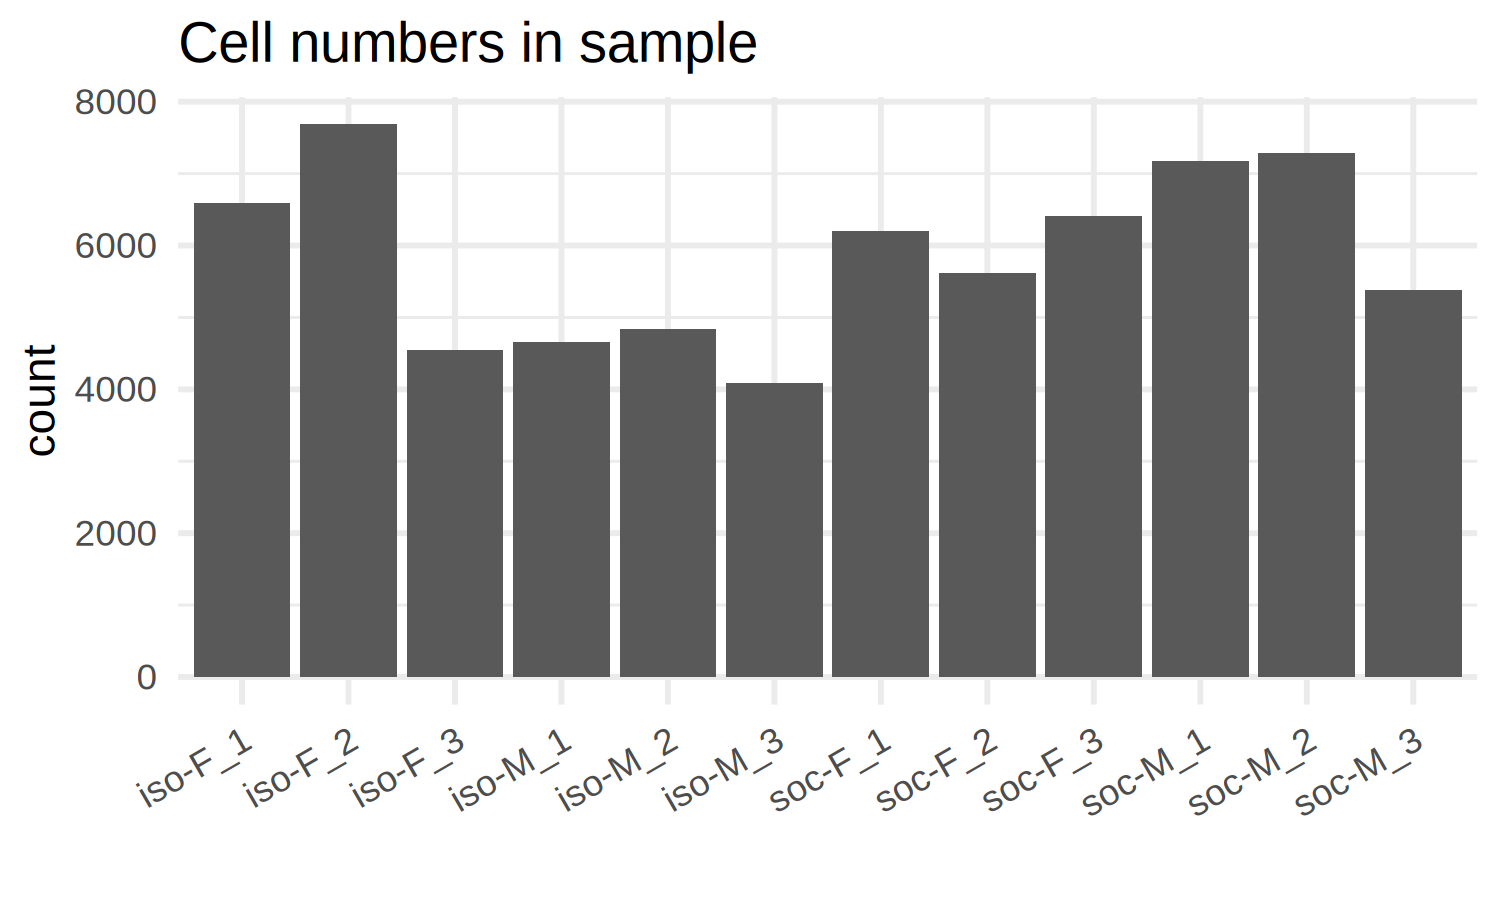

In [18]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)
seu_obj@meta.data %>%
    ggplot(aes(x=sample_name))+
    geom_bar(stat="count")+
    theme_minimal()+
    ggtitle("Cell numbers in sample")+
    theme(axis.text.x = element_text(angle=30,vjust=1,hjust=1))+
    labs(x="")

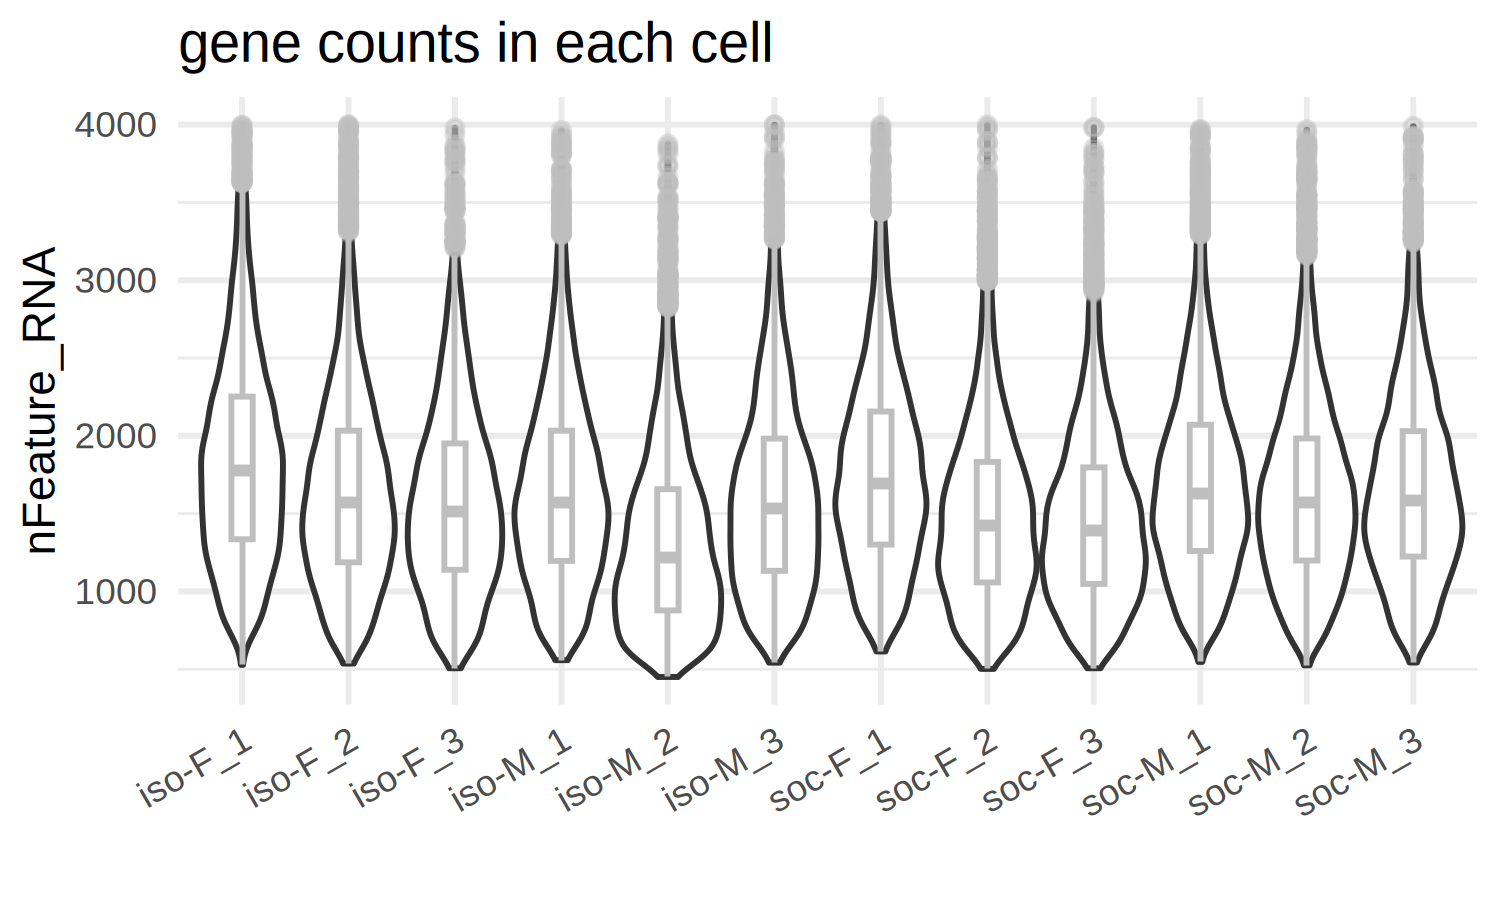

In [5]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)
seu_obj@meta.data %>%
    ggplot(aes(x=sample_name,y=nFeature_RNA))+
    geom_violin(width=1,position = position_dodge(0.9)) +
    geom_boxplot(width=0.2, color="grey", alpha=0.4,position = position_dodge(0.9))+
    theme_minimal()+
    ggtitle("gene counts in each cell")+
    theme(axis.text.x = element_text(angle=30,vjust=1,hjust=1))+
    labs(x="")

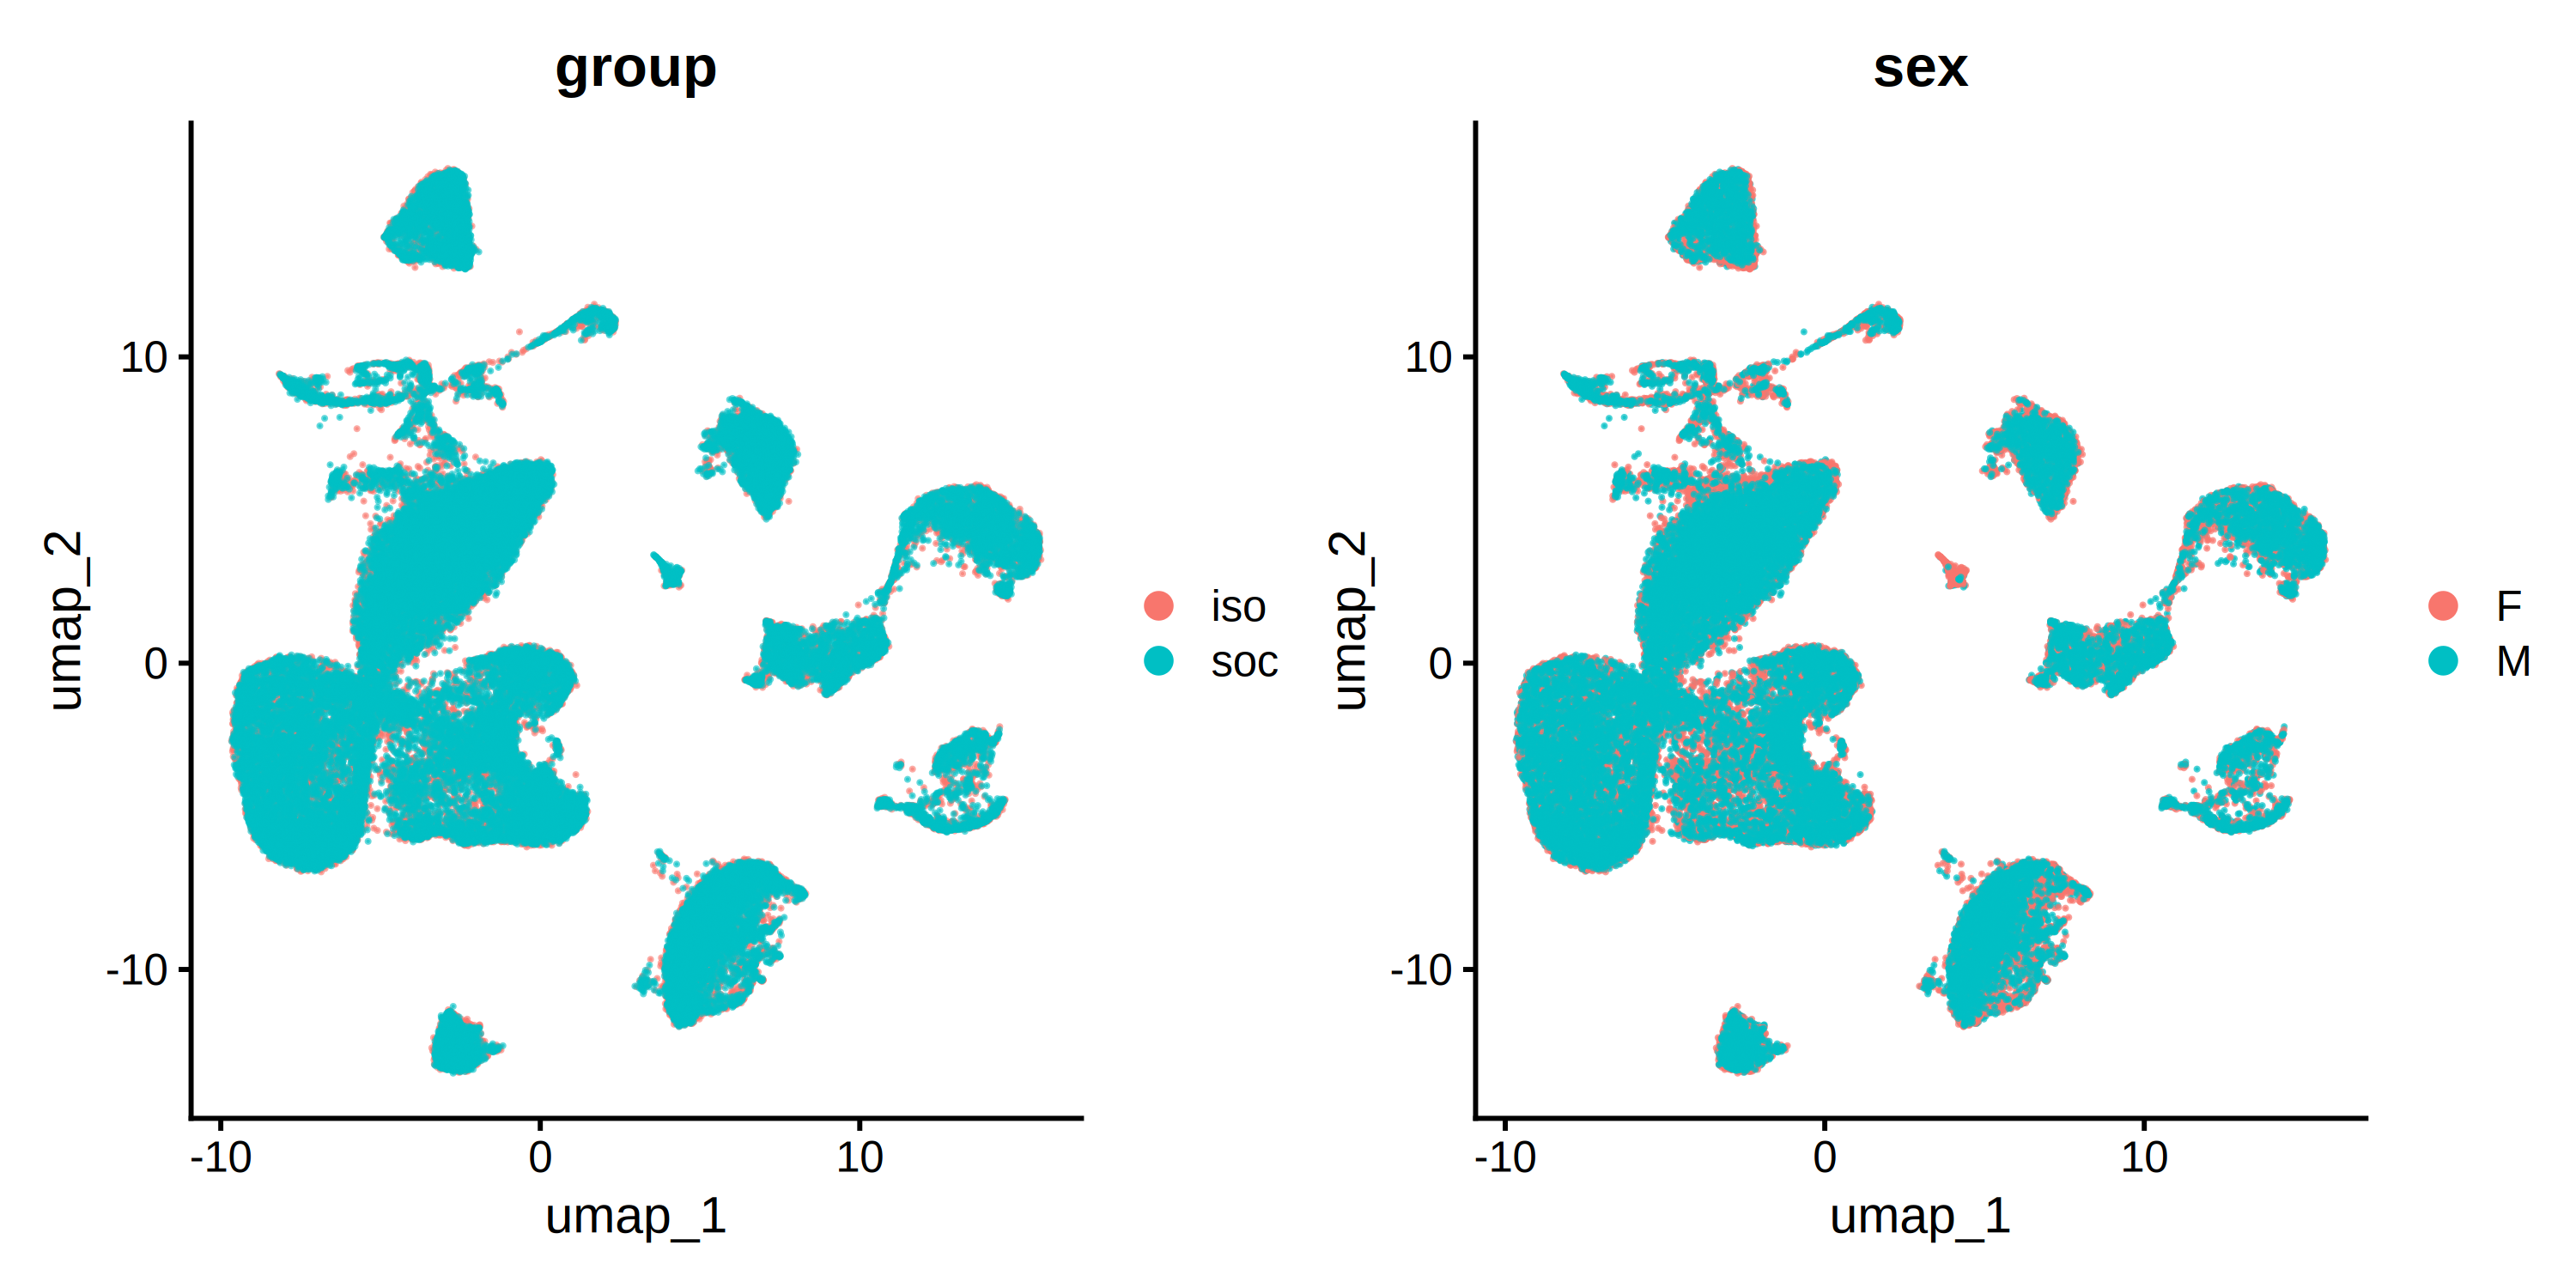

In [5]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)
p1 <- DimPlot(seu_obj, reduction = "umap", group.by = "group",alpha=0.6)
p2 <- DimPlot(seu_obj, reduction = "umap", group.by = "sex",alpha=0.7)
p1+p2

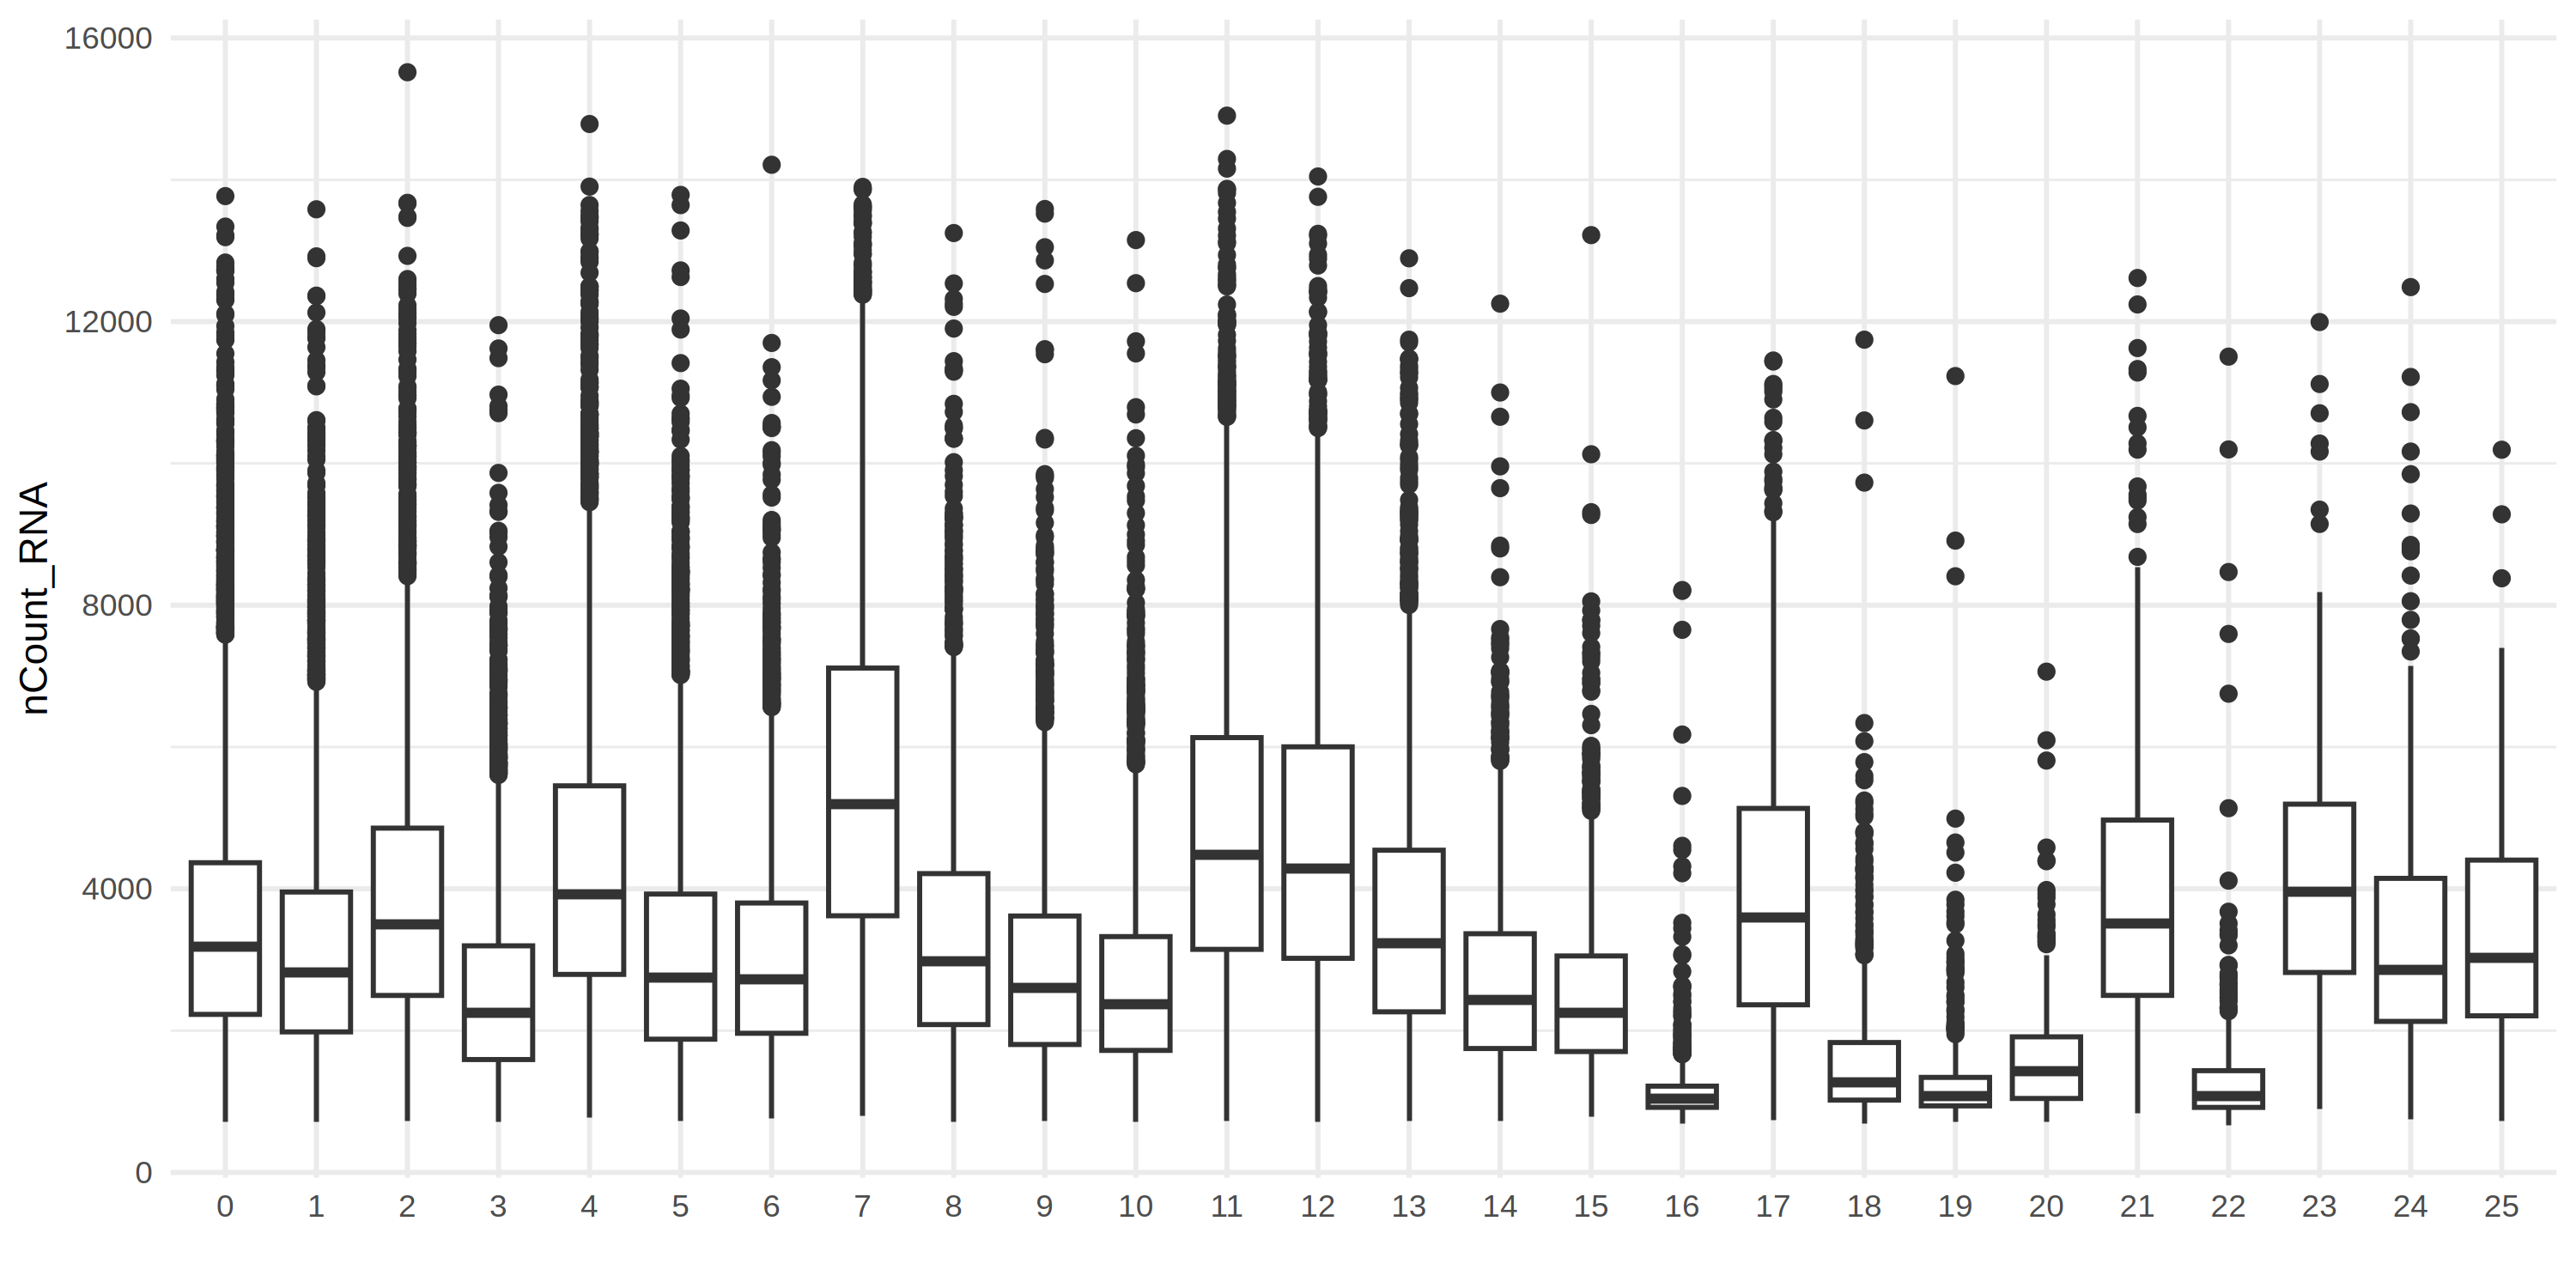

In [6]:
seu_obj@meta.data %>%
    ggplot(aes(x=seurat_clusters,y=nCount_RNA))+
    geom_boxplot()+
    theme_minimal()+
    scale_x_discrete(name="")